# <a id='toc1_'></a>[__Анализ данных в задаче кредитного скоринга__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Анализ данных в задаче кредитного скоринга__](#toc1_)    
  - [__Импорты модулей и настройки__](#toc1_1_)    
  - [__Объявление вспомогательных объектов__](#toc1_2_)    
  - [__Словарь переменных датасета__](#toc1_3_)    
  - [__Цель__](#toc1_4_)    
  - [__Обзор данных__](#toc1_5_)    
  - [__Влияние размера кредитного лимита `LIMIT_BAL`__](#toc1_6_)    
    - [__Описательные статистики. Распределение в разрезе `default`__](#toc1_6_1_)    
    - [__Доли невозвратных кредитов__](#toc1_6_2_)    
    - [__Гипотеза о равенстве медиан. Биномиальное распределение__](#toc1_6_3_)    
    - [__*Плюс бутстреп, минус джекнайф*__](#toc1_6_4_)    
    - [__Гипотеза об общности порождающего распределения. U-тест Манна-Уитни__](#toc1_6_5_)    
    - [__Выводы__](#toc1_6_6_)    
  - [__Влияние пола клиента `SEX`__](#toc1_7_)    
    - [__Исследование связей с помощью индекса Кетле__](#toc1_7_1_)    
    - [__Сравнение гендерного состава подгрупп `default`__](#toc1_7_2_)    
      - [__Доверительный интервал для доли__](#toc1_7_2_1_)    
      - [__Доверительный интервал для разности долей независимых выборок__](#toc1_7_2_2_)    
      - [__z-критерий для разности долей в независимых выборках__](#toc1_7_2_3_)    
      - [__Биномиальный тест__](#toc1_7_2_4_)    
    - [__Выводы__](#toc1_7_3_)    
  - [__Влияние уровня образования `EDUCATION`__](#toc1_8_)    
    - [__Исследование связей с помощью индекса Кетле__](#toc1_8_1_)    
    - [__Выводы__](#toc1_8_2_)    
  - [__Влияние семейного положения `MARRIAGE`__](#toc1_9_)    
    - [__Исследование связей с помощью индекса Кетле__](#toc1_9_1_)    
    - [__Выводы__](#toc1_9_2_)    
  - [__Влияние возраста клиента `AGE`__](#toc1_10_)    
    - [__Описательные статистики. Распределение в разрезе `default`__](#toc1_10_1_)    
    - [__Гипотеза о равенстве медиан. Критерий Краскела-Уоллиса. Медианный тест__](#toc1_10_2_)    
    - [__Гипотеза об общности порождающего распределения__](#toc1_10_3_)    
      - [__Перестановочный тест__](#toc1_10_3_1_)    
      - [__U-тест Манна-Уитни. Тест Колмогорова-Смирнова__](#toc1_10_3_2_)    
      - [__Оценка мощности статистического теста симуляциями Монте-Карло__](#toc1_10_3_3_)    
      - [__Исследование связей с помощью индекса Кетле__](#toc1_10_3_4_)    
    - [__Выводы__](#toc1_10_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Импорты модулей и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from collections.abc import Callable, Iterable
from typing import Any
import collections
import dataclasses
import functools
import itertools

In [2]:
# сторонние библиотеки
from astropy.stats import jackknife_stats
from scipy import stats
from scipy.integrate import quad
from scipy.special import binom
from statsmodels.stats.descriptivestats import describe
from statsmodels.stats.proportion import proportion_confint
from matplotlib.ticker import FormatStrFormatter
from tqdm.notebook import tqdm
import altair
import black
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

***
## <a id='toc1_2_'></a>[__Объявление вспомогательных объектов__](#toc0_)

In [4]:
# контрольный уровень статистической значимости
ALPHA = 0.05

In [5]:
# вспомогательный композитный тип данных
array_like = list[float] | tuple[float] | np.ndarray | pd.Series

In [6]:
@dataclasses.dataclass
class ConfidenceIntervalTemplate:
    """
    Шаблон для наследования. Доверительный интервал с методом 
    проверки на пересечение с другим доверительным интервалом.
    """
    sample: array_like
    alpha: float = ALPHA
    
    def __repr__(self) -> str:
        attrs = {**self.__dict__}
        del attrs['sample']
        return black.format_str(str(attrs), mode=black.Mode())
    
    def is_overlapping(self, other) -> bool:
        if not isinstance(other, self.__class__):
            return NotImplemented
        min_upper = min(self.upper, other.upper)
        max_lower = max(self.lower, other.lower)
        return min_upper >= max_lower

In [7]:
def print_black(collection: Any) -> None:
    """
    Вывод коллекции в наглядном структурированном виде. 
    """
    print(black.format_str(repr(collection), mode=black.Mode()))

***
## <a id='toc1_3_'></a>[__Словарь переменных датасета__](#toc0_)

[__Default of credit card clients__](http://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

* `LIMIT_BAL`: __Размер кредитного лимита__. Amount of credit provided (in New Taiwanese dollar) including
individual consumer credit and the family (supplementary) credit.
* `SEX`: __Пол__ (`1` = мужской, `2` = женский).
* `EDUCATION`: __Уровень образования__ (`0` = доктор, `1` = магистр, `2` = бакалавр, `3` = выпускник школы, `4` = начальное образование, `5` = прочее, `6` = нет данных).
* `MARRIAGE`: __Семейное положение__ (`0` = отказываюсь отвечать, `1` = в браке, `2` = холост, `3` = нет данных).
* `AGE`: __Возраст__ в годах.
* `PAY_1`–`PAY_6`: __История *статусов* платежей по кредиту__. A record of past payments. Past monthly payments, recorded
from April to September, are stored in these columns. PAY_1 represents the repayment status in September; PAY_2 is the repayment status in August; and so on up to PAY_6, which represents the repayment status in April.
The measurement scale for the repayment status is as follows: `0` = pay duly, `1` =
payment delay for 1 month, `2` = payment delay for 2 months and so on up to `8` =
payment delay for 8 months.
* `BILL_AMT1`–`BILL_AMT6`: __Сумма задолженности по состоянию на тот или иной месяц__. Bill statement amount (in NT dollar).
`BILL_AMT1` represents the bill statement amount in September, `BILL_AMT2`
represents the bill statement amount in August and so on up to `BILL_AMT6`
which represents the bill statement amount in April.
* `PAY_AMT1`–`PAY_AMT6`: __История *сумм* платежей по кредиту__. Amount of previous payment (NT dollar). `PAY_AMT1` represents the amount paid in September, `PAY_AMT2` represents the amount paid in August and so on up to `PAY_AMT6` which represents the amount paid in April.
* `default` - __бинарный индикатор невозврата (`1`) денежных средств__.

***
## <a id='toc1_4_'></a>[__Цель__](#toc0_)

Изучить влияние характеристик заемщика на событие невозврата кредита с позиций статистической и практической значимости.  

***
## <a id='toc1_5_'></a>[__Обзор данных__](#toc0_)

In [8]:
# загрузка датасета и случайные пять записей
data = pd.read_csv('credit_card_default_analysis.csv')
data.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
9185,9186,260000,2,1,2,25,0,0,0,0,...,15393,22746,2946,9188,13907,3015,10413,2960,3820,0
26796,26797,160000,1,1,2,28,0,0,0,0,...,4080,3390,390,13695,390,4080,3390,390,390,0
7315,7316,200000,1,2,2,44,0,0,0,0,...,3393,1340,3416,2306,1234,3510,1344,3426,6324,0
25043,25044,150000,1,2,1,52,2,2,2,2,...,146050,142241,145559,8100,8100,9000,0,5578,5304,1
26518,26519,30000,2,3,1,51,1,2,2,0,...,30332,29871,28977,2000,0,1962,1395,1000,2000,0


In [9]:
# обзор типов данных переменных датасета и полноты их значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_0      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

***
## <a id='toc1_6_'></a>[__Влияние размера кредитного лимита `LIMIT_BAL`__](#toc0_)

***
### <a id='toc1_6_1_'></a>[__Описательные статистики. Распределение в разрезе `default`__](#toc0_)

In [10]:
# описательные статистики для LIMIT_BAL и default
# раскоментировать вторую строку для расширенной статистики

data[['LIMIT_BAL', 'default']].describe()
# describe(data[['LIMIT_BAL', 'default']])

,LIMIT_BAL,default
count,30000.000000,30000.000000
mean,167484.322667,0.221200
std,129747.661567,0.415062
min,10000.000000,0.000000
25%,50000.000000,0.000000
50%,140000.000000,0.000000
75%,240000.000000,0.000000
max,1000000.000000,1.000000


In [11]:
# контейнер для сбора выборок
samples = []

# выборки LIMIT_BAL для обеих подгрупп default
for default in (0, 1):
    sample = data.query(f'default == {default}').LIMIT_BAL
    
    # метка default и переменная датасета-источник выборки 
    # сохраняются в словаре атрибутов sample, объекте pd.Series
    sample.attrs['feature'] = 'LIMIT_BAL'
    sample.attrs['default'] = default
    samples.append(sample)

In [12]:
# описательные статистики для LIMIT_BAL, подгруппа default=0
# раскоментировать вторую строку для расширенной статистики

samples[0].describe()
# describe(samples[0])

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [13]:
# описательные статистики для LIMIT_BAL, подгруппа default=1
# раскоментировать вторую строку для расширенной статистики

samples[1].describe()
# describe(samples[1])

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

In [14]:
# объемы подгрупп default в долях от датасета
data.default.value_counts(normalize=True)

default
0    0.7788
1    0.2212
Name: proportion, dtype: float64

In [15]:
# заголовок графика
title = 'Объемы подгрупп default в абсолютных частотах'

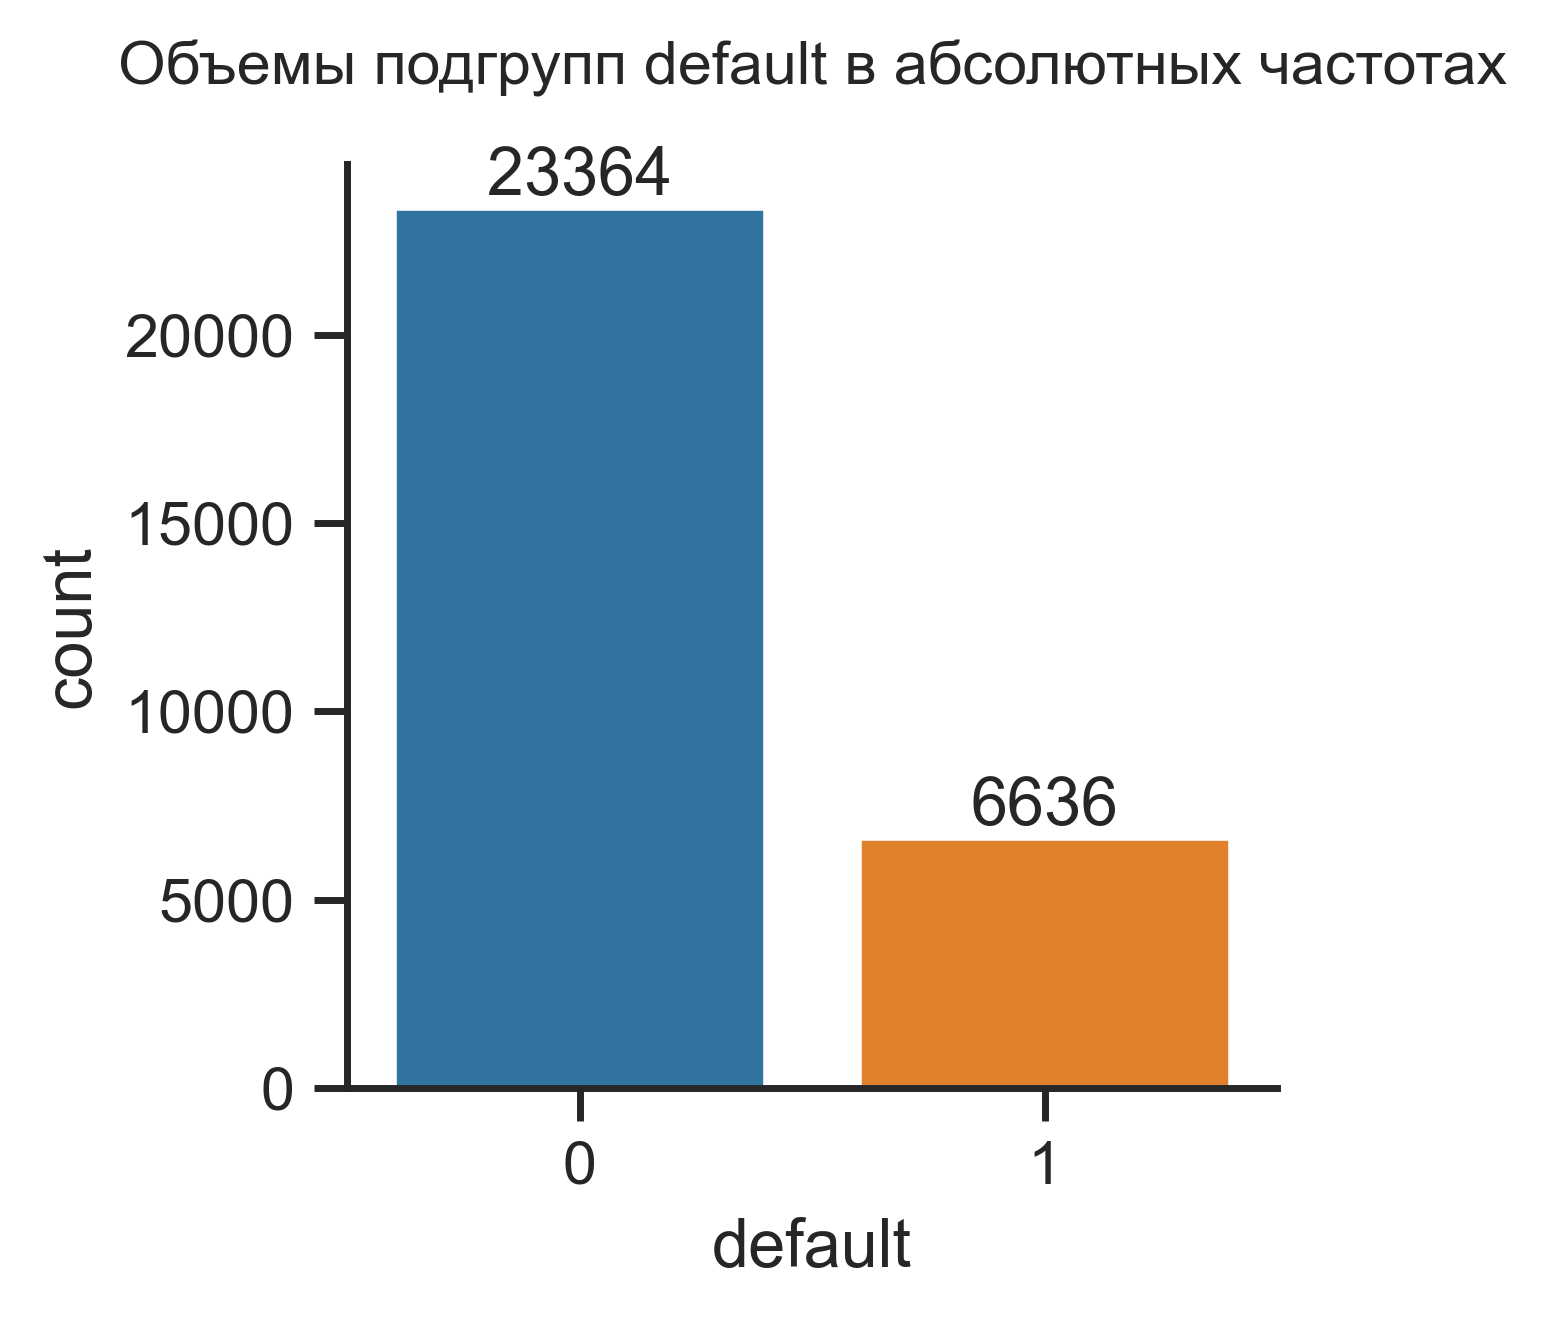

In [16]:
# объемы подгрупп default в абсолютных частотах
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(data, x='default', ax=ax)
ax.bar_label(ax.containers[0])
plt.title(title, size=11, y=1.05)
plt.show()

In [17]:
# медианы выборок LIMIT_BAL для обеих подгрупп default
medians = list(map(np.median, samples))

In [18]:
# параметры бинаризации LIMIT_BAL
binning = dict(bins=20, binrange=(0, 1e6))

In [19]:
# заголовок графика и комментарий
title = 'Гистограмма распределения LIMIT_BAL в разрезе default'
comment = 'Ширина бина 1 млн / 20 = 50 тыс.\nNew Taiwanese dollar (NT)'

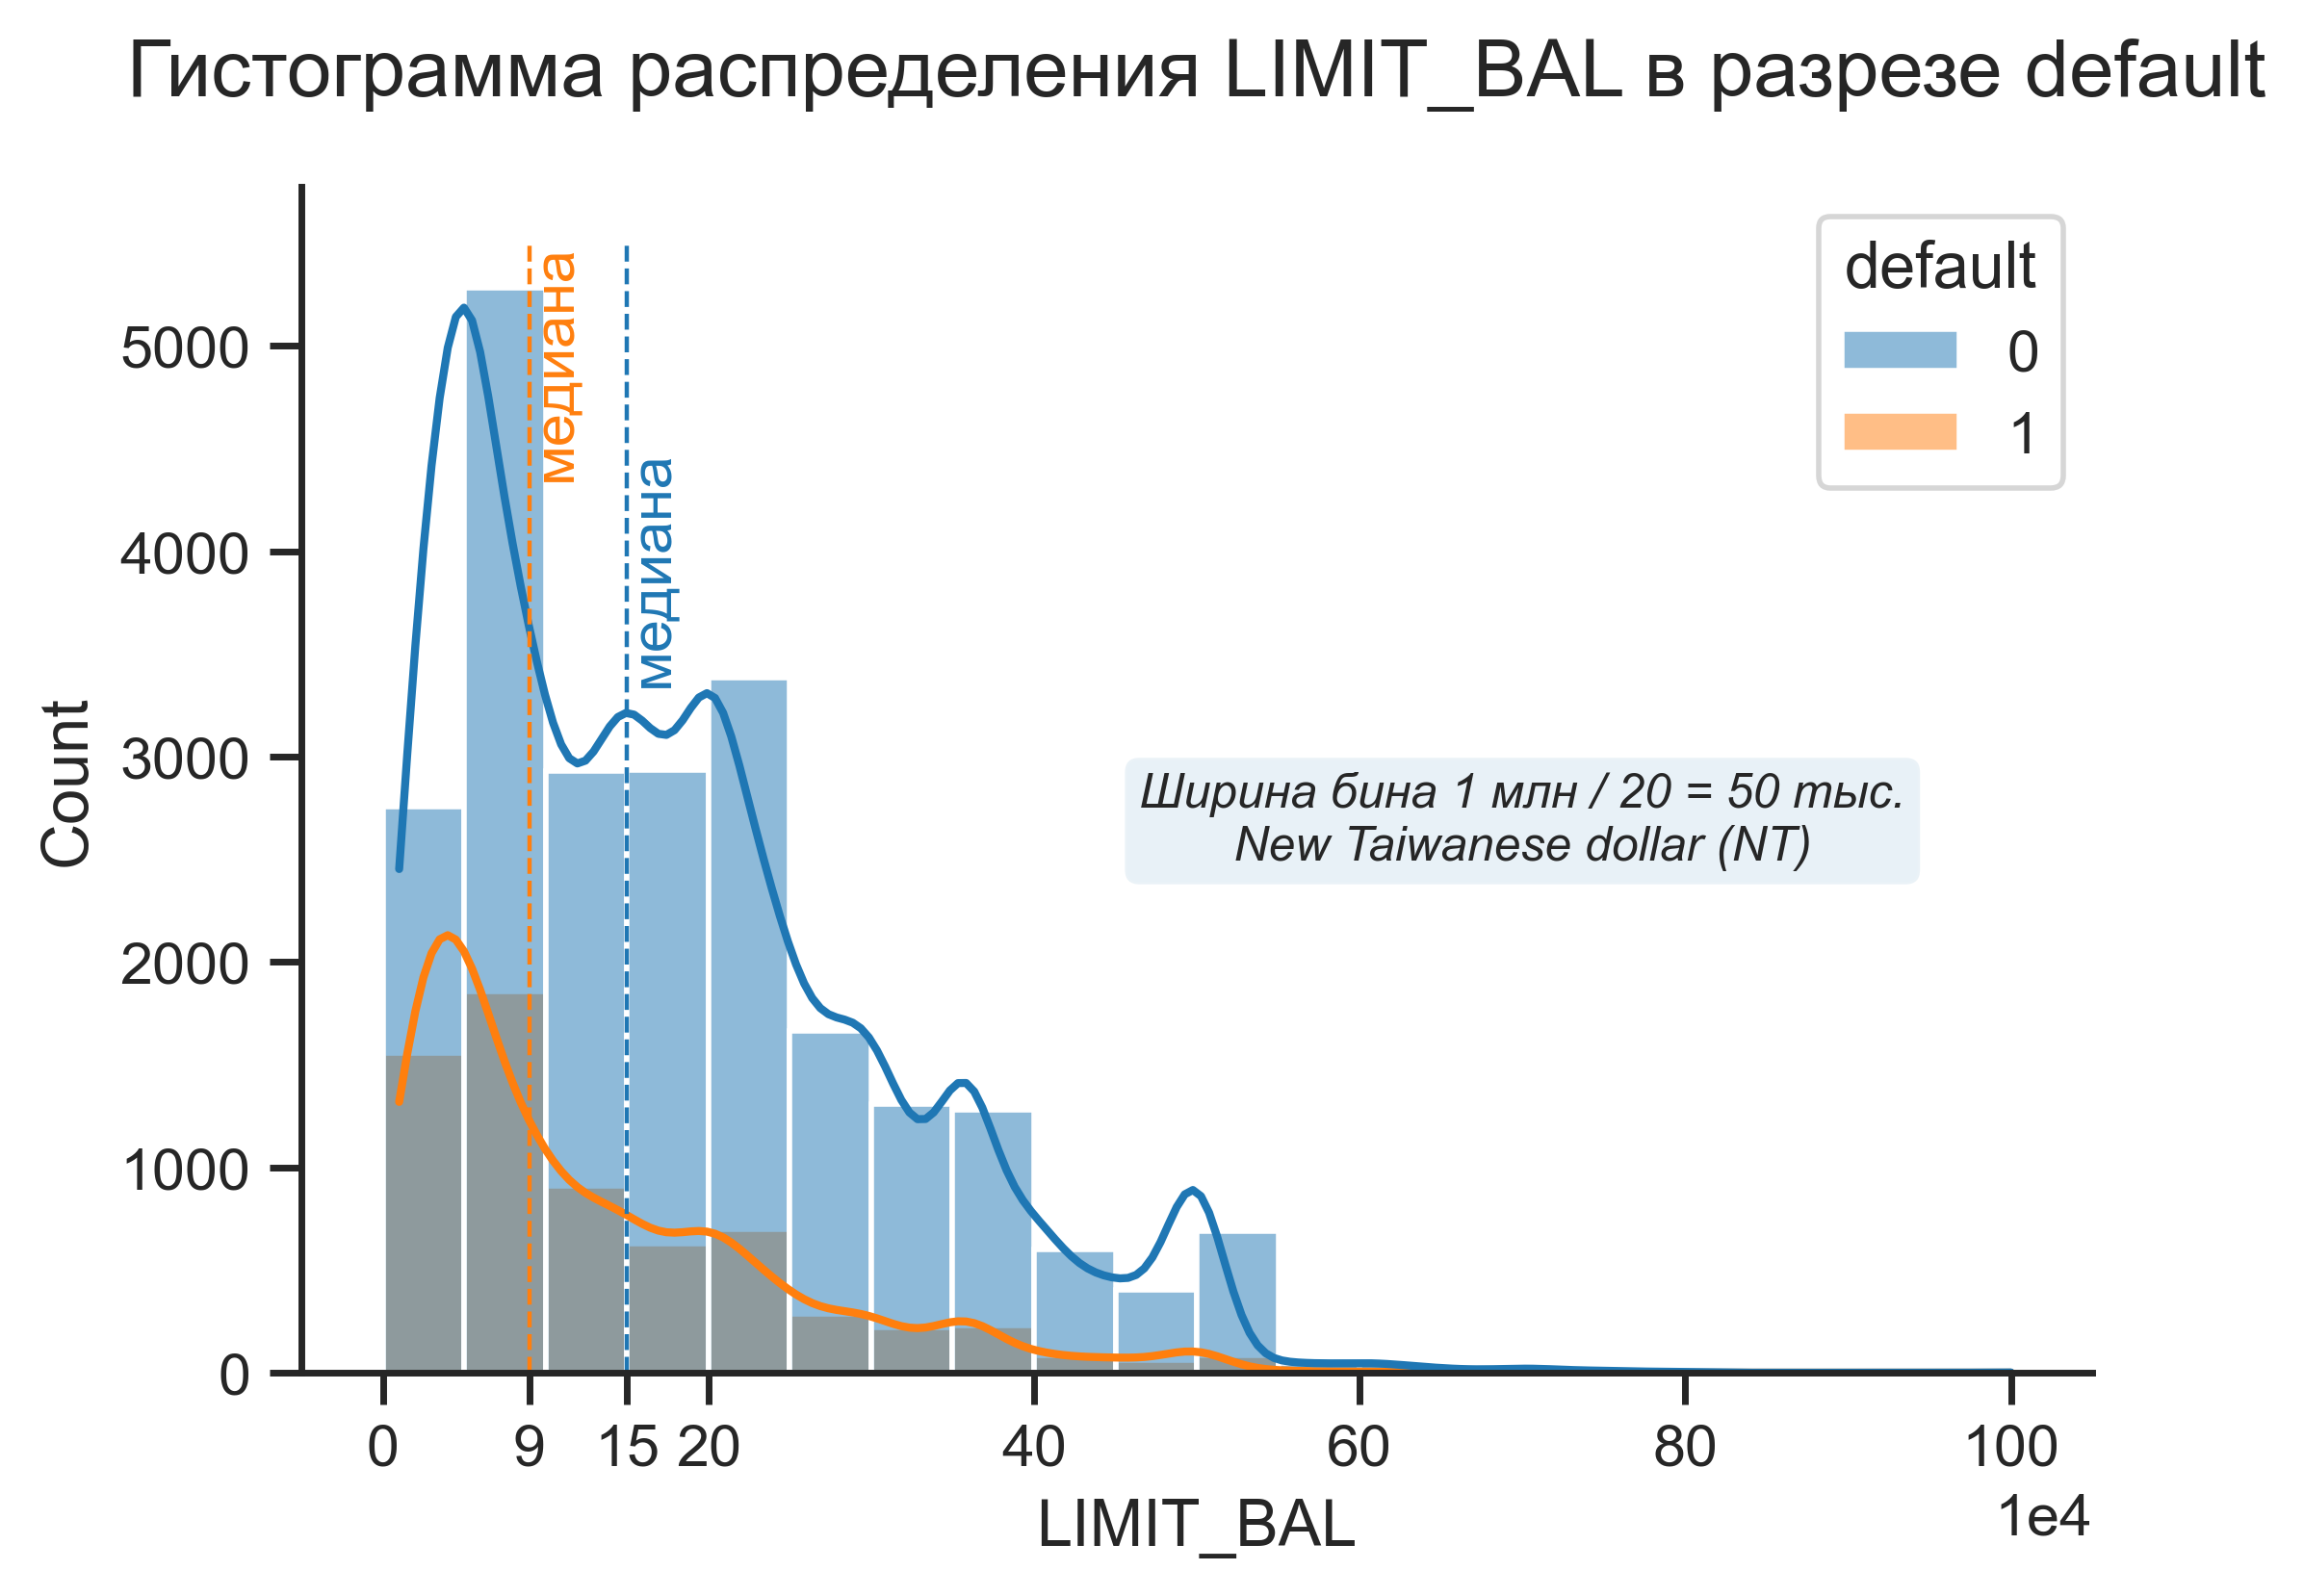

In [20]:
# гистограмма распределения LIMIT_BAL в разрезе default
plt.figure(figsize=(6,4))
sns.histplot(data, x='LIMIT_BAL', hue='default', **binning, kde=True)
plt.vlines(medians, 0, 5500, colors=['C0', 'C1'], ls='dashed', lw=0.8)

for n, yloc in enumerate([3400, 4400]):
    plt.annotate(
        'медиана', xy=(medians[n], yloc), size=11, c=f'C{n}', rotation=90
    )

plt.annotate(
    comment, xy=(7e5, 2.5e3), fontsize=9, fontstyle='italic',
    bbox=dict(boxstyle='round', alpha=0.1), ha='center'
)

plt.xticks(np.arange(0, 1.2e6, 2e5).tolist() + medians)
plt.ticklabel_format(axis='x', style='sci', scilimits=(4,4))
plt.title(title, size=15, y=1.05)
plt.show()

***
### <a id='toc1_6_2_'></a>[__Доли невозвратных кредитов__](#toc0_)

Для каждого из $20$ бинов `LIMIT_BAL` шириной $50$ тыс. NT посчитаем и визуализируем долю невозвратных кредитов как отношение числа наблюдений с меткой `default=1` к числу наблюдений с меткой `default=0` внутри бина.

[__numpy.histogram__](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html#numpy-histogram)
>__*density*__ bool, optional<br>
If False, the result will contain the number of samples in each bin.

[__numpy.errstate__](https://numpy.org/doc/stable/reference/generated/numpy.errstate.html#numpy-errstate)
>Context manager for floating-point error handling.<br>
Using an instance of errstate as a context manager allows statements in that context to execute with a known error handling behavior.

[__numpy.nan_to_num__](https://numpy.org/doc/stable/reference/generated/numpy.nan_to_num.html#numpy-nan-to-num)
>Replace NaN with zero and infinity with large finite numbers (default behaviour) or with the numbers defined by the user using the _nan_, _posinf_ and/or _neginf_ keywords.

In [21]:
# побиновый подсчет числа наблюдений
bin_counts = [
    np.histogram(sample, bins=20, range=(0, 1e6), density=False)[0]
    for sample in samples[::-1]
]

# доли невозвратных кредитов
with np.errstate(invalid='ignore'):    
    failed = np.nan_to_num(np.divide(*bin_counts))
    
failed

array([0.56422351, 0.35157137, 0.3105802 , 0.21377429, 0.20656028,
       0.1732852 , 0.16806723, 0.18110851, 0.13833333, 0.15136476,
       0.12445731, 0.19148936, 0.11111111, 0.07692308, 0.16666667,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [22]:
# метки для оси абсцисс графика долей невозвратных кредитов
r = range(0, 1050, 50)
labels = [f'{from_}-{to}k' for from_, to, in zip(r[:-1], r[1:])]

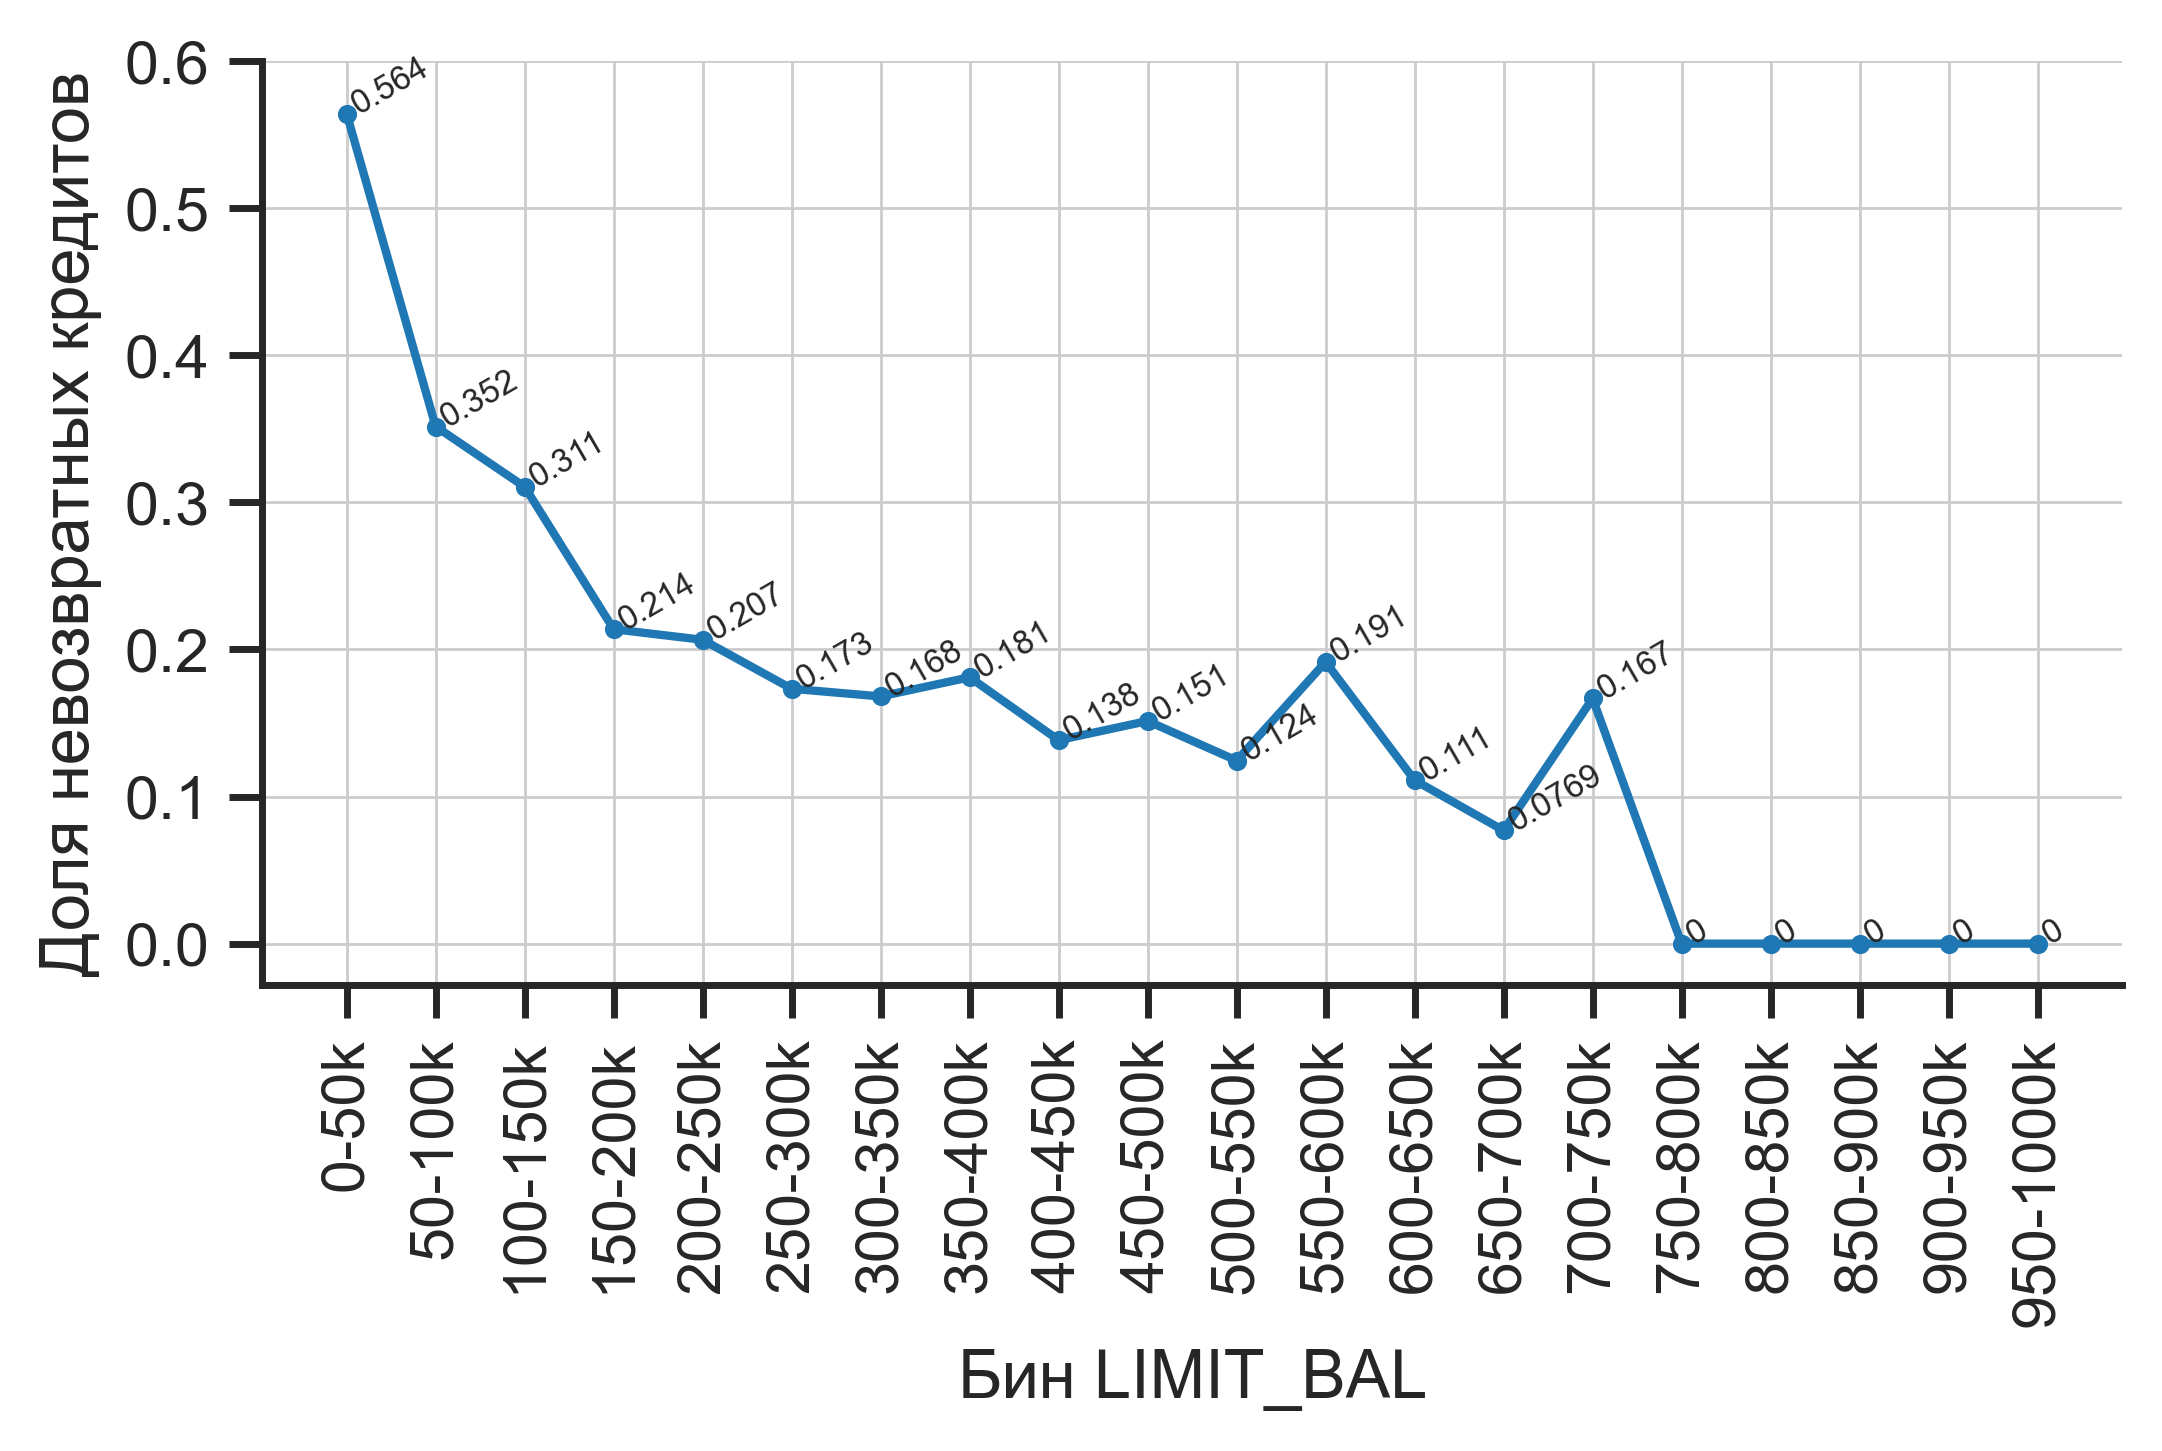

In [23]:
# график долей невозвратных кредитов
plt.figure(figsize=(6,3))
plt.plot(failed)
plt.scatter(range(20), failed, s=6)
for i, value in enumerate(failed):
    plt.annotate(f'{value:.3g}', (i, value), size=6, rotation=30)
plt.xticks(range(20), labels=labels, rotation=90)
plt.yticks(np.arange(0, 0.7, 0.1))
plt.xlabel('Бин LIMIT_BAL')
plt.ylabel('Доля невозвратных кредитов')
plt.grid(lw=0.5)
plt.show()

***
### <a id='toc1_6_3_'></a>[__Гипотеза о равенстве медиан. Биномиальное распределение__](#toc0_)

Проверим гипотезу о равенстве медианных значений кредитного лимита `LIMIT_BAL` в разрезе индикатора невозврата кредита `default` с помощью биномиального распределения.

Случайная величина — число элементов выборки, которые больше (или меньше) медианы, имеет биномиальное распределение с параметром $p = 0.5$ (вероятность попасть по любую сторону относительно _центрального_ элемента вариационного ряда). Значит, границы доверительного интервала для данной случайной величины — это индексы элементов вариационного ряда, которые являются границами доверительного интервала для медианы выборки, по которой построен вариационный ряд.

[__scipy.stats.binom__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html#scipy-stats-binom)
>A binomial discrete random variable.

>__*interval(confidence, n, p, loc=0)*__<br>
>Confidence interval with equal areas around the median.

In [24]:
@dataclasses.dataclass(repr=False)
class QuantileConfidenceInterval(ConfidenceIntervalTemplate):
    """
    Доверительный интервал для квантиля выборки.
    """
    quantile: float = 0.5  # медиана по умолчанию
    
    def __post_init__(self) -> None:
        # default и переменная датасета-источник выборки, хранящиеся 
        # в словаре атрибутов sample, если sample - объект pd.Series
        if hasattr(self.sample, 'attrs'):
            self.feature = self.sample.attrs.get('feature')
            self.default = self.sample.attrs.get('default')
        
        # инициализация биномиально распределенной случайной величины
        rv = stats.binom(len(self.sample), self.quantile)
        
        # scipy.stats._distn_infrastructure.interval https://t.ly/Nu4d1
        r, s = map(int, rv.interval(1 - self.alpha))
        
        # фактический уровень доверия, отличающийся от 1 - self.alpha 
        # ввиду дискретности биномиального распределения
        self.conf_level = rv.cdf(s) - rv.cdf(r)
        
        # границы дов. интервала фактического уровня доверия для медианы 
        # sample - выборки, по которой построен вариационный ряд
        self.lower, self.upper = np.sort(self.sample)[[r-1, s-1]]

Построение доверительных интервалов для медианы выборок `LIMIT_BAL` обеих подгрупп `default`:

In [25]:
limitbal0, limitbal1 = map(QuantileConfidenceInterval, samples)

In [26]:
# проверка доверительных интервалов на пересечение
limitbal0.is_overlapping(limitbal1)

False

In [27]:
# сами доверительные интервалы
limitbal0, limitbal1

({
     "alpha": 0.05,
     "quantile": 0.5,
     "feature": "LIMIT_BAL",
     "default": 0,
     "conf_level": 0.950313101868973,
     "lower": 150000,
     "upper": 150000,
 },
 {
     "alpha": 0.05,
     "quantile": 0.5,
     "feature": "LIMIT_BAL",
     "default": 1,
     "conf_level": 0.950474193984723,
     "lower": 80000,
     "upper": 90000,
 })

См. также апроксимацию биномиального распределения нормальным:
* _Practical Nonparametric Statistics_, 3rd edition — Conover W. J. — стр. 67-68.
* _Statistics with Confidence_, 2nd edition — Douglas G. Altman — стр. 37-39:

$$\large r_q = nq - z_{1 - \frac{\alpha}{2}} \cdot \sqrt{nq(1-q)}$$ 
$$\large s_q = 1 + nq + z_{1 - \frac{\alpha}{2}} \cdot \sqrt{nq(1-q)}$$

при $n > 20$.

__Доверительные интервалы для медианы выборок `LIMIT_BAL` обеих подгрупп `default` не пересекаются, поэтому гипотеза о равенстве медиан `LIMIT_BAL` в разрезе `default` отклоняется на уровне значимости `ALPHA`.__

***
### <a id='toc1_6_4_'></a>[__*Плюс бутстреп, минус джекнайф*__](#toc0_)

Покажем, что бутстреп пригоден для оценки медианы, а джекнайф — нет.

__Бутстреп__ основан на некотором количестве, например $1000$, случайных испытаний. 
Каждое испытание состоит из $n$ случайных выборов объектов из выборки
с возвращением, где $n$ — это количество объектов в исходном множестве.
Поскольку проводится выбор с возвращением, некоторые объекты могут быть
выбраны несколько раз, а другие останутся не выбранными ни разу. Нетрудно
убедиться, что в среднем $\frac{e-1}{e} \approx 63.2\%$ всех объектов попадут в выборку
одного испытания. Действительно, при каждом случайном
выборе из множества размером $n$, вероятность не быть выбранным для любого
объекта составляет $1 - \frac{1}{n}$. Поэтому вероятность быть не выбранным при $n$
независимых выборах равна 

$$\large \left(1 - \frac{1}{n}\right)^n \approx \frac{1}{e} \approx 36.8\%$$
от общего числа объектов (при $n \to \infty$ т.н. _первый замечательный предел_).

[__scipy.stats.bootstrap__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html#scipy-stats-bootstrap)

>Compute a two-sided bootstrap confidence interval of a statistic.
When method is 'percentile' and alternative is 'two-sided', a bootstrap confidence interval is computed according to the following procedure.
>1. Resample the data: for each sample in data and for each of n_resamples, take a random sample of the original sample (with replacement) of the same size as the original sample.
>2. Compute the bootstrap distribution of the statistic: for each set of resamples, compute the test statistic.
>3. Determine the confidence interval: find the interval of the bootstrap distribution that is 
> * symmetric about the median and 
> * contains confidence_level of the resampled statistic values.

In [28]:
def bootstrap(sample: pd.Series) -> str:
    """
    0.95-доверительный интервал 
    для бутстреп-выборки медианы.
    """
    ci = stats.bootstrap(
        sample.values.reshape(1,-1), 
        np.median, 
        n_resamples=1000,
        method='basic',
        # confidence_level=0.95 по умолчанию
        # alternative='two-sided' по умолчанию
    ).confidence_interval
    return f'bootstrap: {ci}'

__Джекнайф-выборками__ $X_{[1]},X_{[2]},\dots,X_{[n]}$ называются наборы, формируемые из исходной выборки следующим образом:

$$\large X_{[i]} = \left(X_1,\dots,X_{i-1},X_{i+1},\dots,X_n\right),$$

то есть $i$-ая джекнайф-выборка получается из исходной удалением $i$-ого элемента. Вместо одной выборки мы получаем $n$ псевдовыборок. Фактически _jackknife_, или _leave-one-out_, — это частный случай $k$-частной перекрестной валидации (скользящего контроля), когда число $k$ разбиений (фолдов) равно объему выборки $n$.

[__astropy.stats.jackknife_stats__](https://docs.astropy.org/en/stable/api/astropy.stats.jackknife_stats.html#jackknife-stats)
>Performs jackknife estimation on the basis of jackknife resamples.

In [29]:
def jackknife(sample: pd.Series) -> str:
    """
    0.95-доверительный интервал 
    для джекнайф-выборки медианы.
    """
    # confidence_level=0.95 по умолчанию
    ci = jackknife_stats(sample, np.median)[3]
    return f'jackknife: {repr(ci)}'

Построение доверительных интервалов для медианы выборок `LIMIT_BAL` обеих подгрупп `default` бутстрепом и джекнайф:

In [30]:
methods = [bootstrap, jackknife]

for sample in samples:
    default = sample.attrs['default']
    desc = f'LIMIT_BAL sample for {default=}'
    
    for method in tqdm(methods, desc):
        tqdm.write(method(sample))

LIMIT_BAL sample for default=0:   0%|          | 0/2 [00:00<?, ?it/s]

bootstrap: ConfidenceInterval(low=150000.0, high=150000.0)


jackknife: array([150000., 150000.])


LIMIT_BAL sample for default=1:   0%|          | 0/2 [00:00<?, ?it/s]

bootstrap: ConfidenceInterval(low=90000.0, high=100000.0)
jackknife: array([90000., 90000.])


Бутстреп дает результат, аналогичный решению с биномиальным распределением, в то время как джекнайф — две точечные оценки. Общий вывод: классический джекнайф как leave-one-out (именно _one_) работает для оценки только _гладких_ параметров, и не работает для параметров, меняющихся скачкообразно. Обобщенная техника, реализованная, например, в классе [__sklearn.model_selection.LeavePOut__](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeavePOut.html#sklearn-model-selection-leavepout), предполагает исключение $p \ge 1$ элемента, однако при данных объемах выборок `LIMIT_BAL` уже при $p = 2$ задача становится вычислительно затратной: 

In [31]:
# число джекнайф-выборок LIMIT_BAL для обеих подгрупп default
# при исключении двух элементов:
for sample in samples:
    default = sample.attrs['default']
    print(f'{default=}: {int(binom(sample.size, sample.size - 2))}')

default=0: 272926566
default=1: 22014930


***
### <a id='toc1_6_5_'></a>[__Гипотеза об общности порождающего распределения. U-тест Манна-Уитни__](#toc0_)

Проверим гипотезу об общности порождающего распределения для выборок `LIMIT_BAL`, соответствующих разным подгруппам `default` с помощью U-теста Манна-Уитни.

[__scipy.stats.mannwhitneyu__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.mannwhitneyu.html#scipy-stats-mannwhitneyu)

>Perform the Mann-Whitney U rank test on two independent samples.<br>
The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y. It is often used as a test of difference in location between distributions.

In [32]:
stats.mannwhitneyu(*samples)

MannwhitneyuResult(statistic=95786286.5, pvalue=1.2255485818223301e-189)

Рассчитаем величину статистики U-теста Манна-Уитни самостоятельно.

In [33]:
# результат U-теста Манна-Уитни именованным кортежем
fields = ['statistic', 'h0_point']
MWUHandmadeResult = collections.namedtuple('MWUHandmadeResult', fields)

In [34]:
def mannwhitneyu_statistic_handmade(
    sample1: array_like, sample2: array_like
) -> MWUHandmadeResult:
    """
    Статистика U-теста Манна-Уитни своими руками.
    """
    statistic = 0
    for x, y in itertools.product(sample1, sample2):
        if x > y:
            statistic += 1
        if x == y:
            statistic += 0.5
    h0_point = len(sample1) * len(sample2) / 2    
    return MWUHandmadeResult(statistic, h0_point)

In [35]:
mannwhitneyu_statistic_handmade(*samples)

MWUHandmadeResult(statistic=95786286.5, h0_point=77521752.0)

Значение статистики, близкое к $n_1 n_2 / 2$, где $n_1, n_2$ — объемы выборок, свидетельствует в пользу $H_0$. В данном случае статистика теста больше полупроизведения объемов выборок `h0_point`, что говорит о том, что выборка, стоящая в аргументах вызова `scipy.stats.mannwhitneyu` на первом месте (`default=0`) _в общем и целом_ локализована правее второй выборки (`default=1`).

__Гипотеза об общности порождающего распределения на уровне значимости `ALPHA` отклонена.__

***
### <a id='toc1_6_6_'></a>[__Выводы__](#toc0_)

Обе гипотезы — о равенстве медиан `LIMIT_BAL` в подгруппах `default` и об общности распределения, порождающего эти подвыборки `LIMIT_BAL`, — отклонены на уровне значимости `ALPHA`. Достигнутые в тестах уровни значимости на много порядков меньше $0.05$. 

Имеет ли это знание о статистически значимом расхождении мер центральной тенденции подвыборок `LIMIT_BAL` практическое значение в плане прогнозирования `default`?

Ответ отрицательный. Полагаю, что некорректно говорить о зависимости `default` от `LIMIT_BAL` потому, что и `default`, и `LIMIT_BAL` на самом деле соподчинены некоторому внутреннему, корневому комплексному признаку, который обобщенно можно назвать _надежностью клиента_. Относительный сдвиг подвыборок `LIMIT_BAL` объясняется тем, что правый хвост распределения `LIMIT_BAL` у благонадежных плательщиков простирается сильно дальше, или, иными словами, `LIMIT_BAL` при `default=0` имеет больший размах. Надо полагать, что больший кредитный лимит соответствует более богатым и стабильным заемщикам, провалы по обязательствам у которых случаются сравнительно реже. Но они случаются реже не потому, что у клиента большой кредитный ресурс, а кредитный ресурс большой и процент невозвратов низкий или нулевой потому, что по обобщенной метрике надежности это благополучный клиент. И именно после высокой оценки клиента по этой метрике банк и одобрил этому клиенту высокий кредитный ресурс. 

Аналогичное рассуждение применяется к клиентам с низким `LIMIT_BAL`. Среди них наивысший процент невозвратов, но он такой не потому, что банк "мало дает в долг", а банк дает мало потому, что невысоко оценивает надежность этих клиентов. И именно поэтому банк страхует свои риски в сегменте малых сумм огромными процентными ставками.

***
## <a id='toc1_7_'></a>[__Влияние пола клиента `SEX`__](#toc0_)

***
### <a id='toc1_7_1_'></a>[__Исследование связей с помощью индекса Кетле__](#toc0_)

Индекс Кетле показывает, на сколько процентов условная вероятность строки в таблице сопряженности отличается от ее безусловной вероятности; чем он больше, тем выше связь номинальных/категориальных признаков.

Подробное объяснение индексов Кетле и их связи с коэффициентом хи-квадрат Пирсона будет дано в следующем разделе на примере другой пары признаков. Сейчас ограничимся выводами, вытекающими из расчетов.

In [36]:
# таблица сопряженности SEX/default
table = pd.crosstab(data.SEX, data.default)
table.index = ['male', 'female']
table.index.name = 'gender'

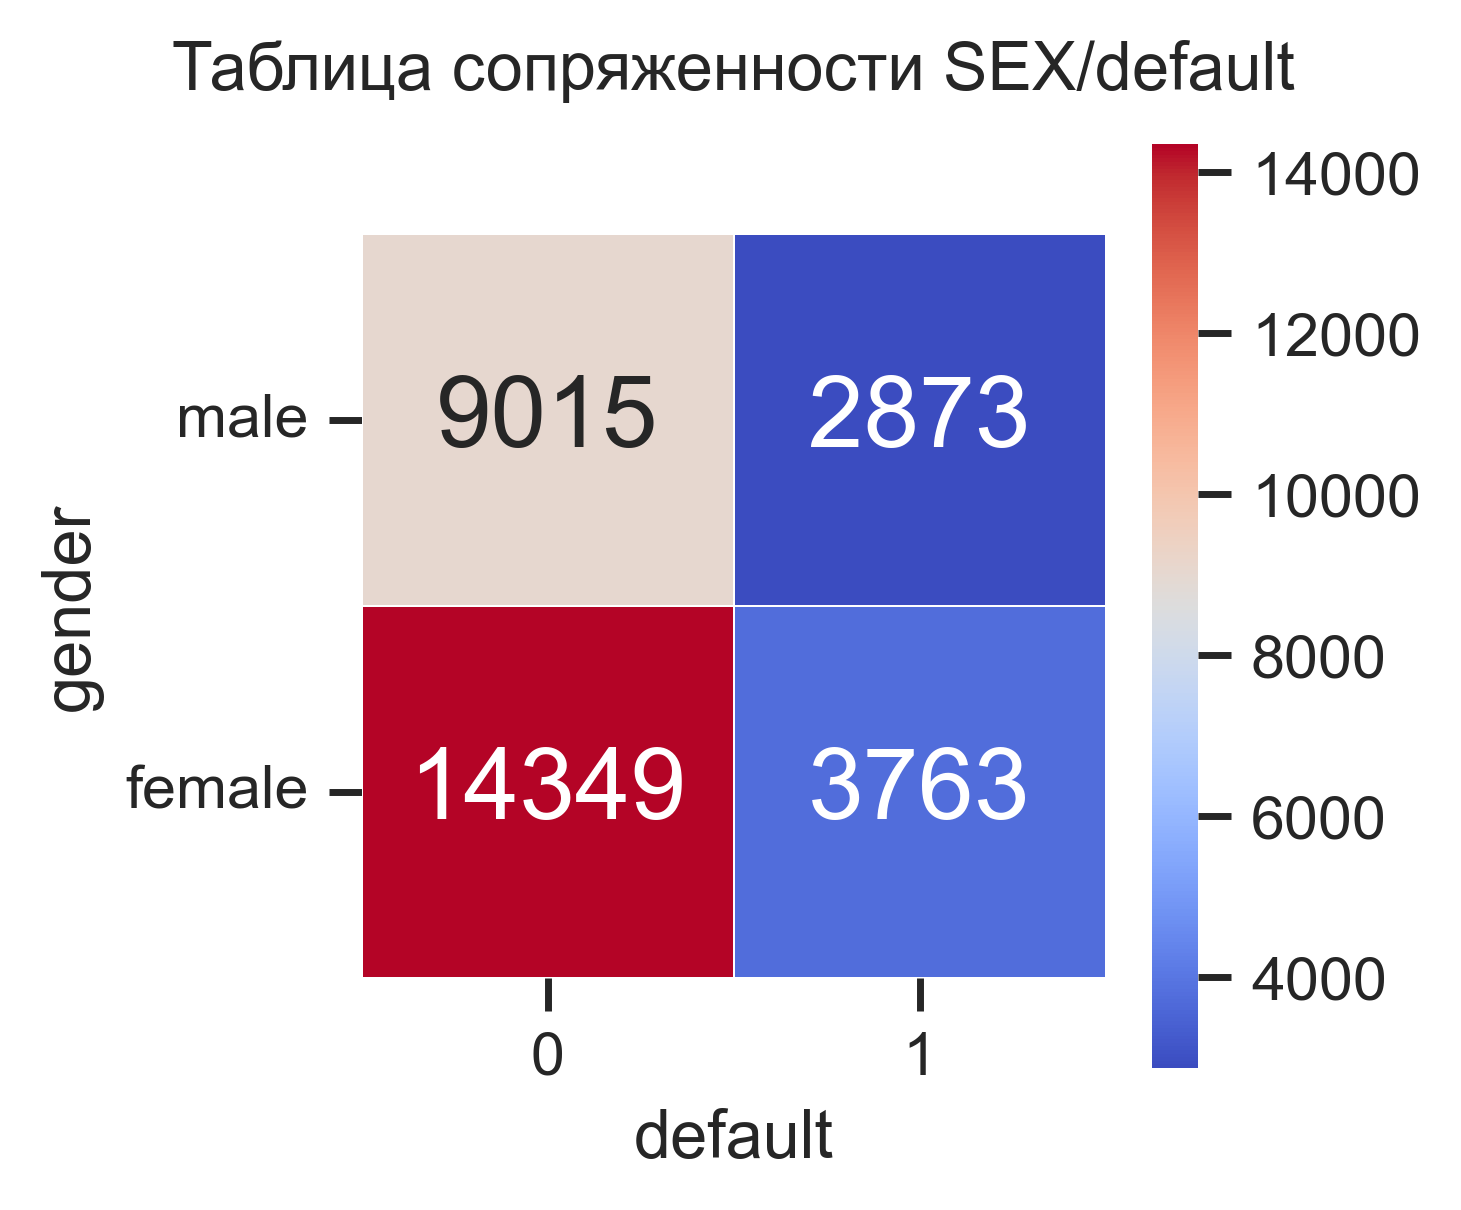

In [37]:
# тепловая карта таблицы сопряженности SEX/default
plt.figure(figsize=(3,3))
sns.heatmap(
    table, annot=True, fmt='d', annot_kws=dict(size=18),
    linewidths=0.3, square=True, cmap='coolwarm'
)
plt.yticks(rotation=0)
plt.title('Таблица сопряженности SEX/default', y=1.15)
plt.show()

In [38]:
def quetelet_index(crosstab: pd.DataFrame) -> np.ndarray:
    """
    Индексы Кетле для ненормализованной таблицы частот
    без маргинальных полей.
    """
    values = crosstab.values
    values = values / values.sum()
    mrow, mcol = stats.contingency.margins(values)
    return (values / mrow - mcol) / mcol

In [39]:
# индексы Кетле для таблицы сопряженности SEX/default
qtable = quetelet_index(table)
qtable = pd.DataFrame(qtable, index=['male', 'female'], columns=[0, 1])
qtable.index.name = 'gender'
qtable.columns.name = 'default'

In [40]:
# заголовок графика
title = 'Индексы Кетле для таблицы сопряженности SEX/default'

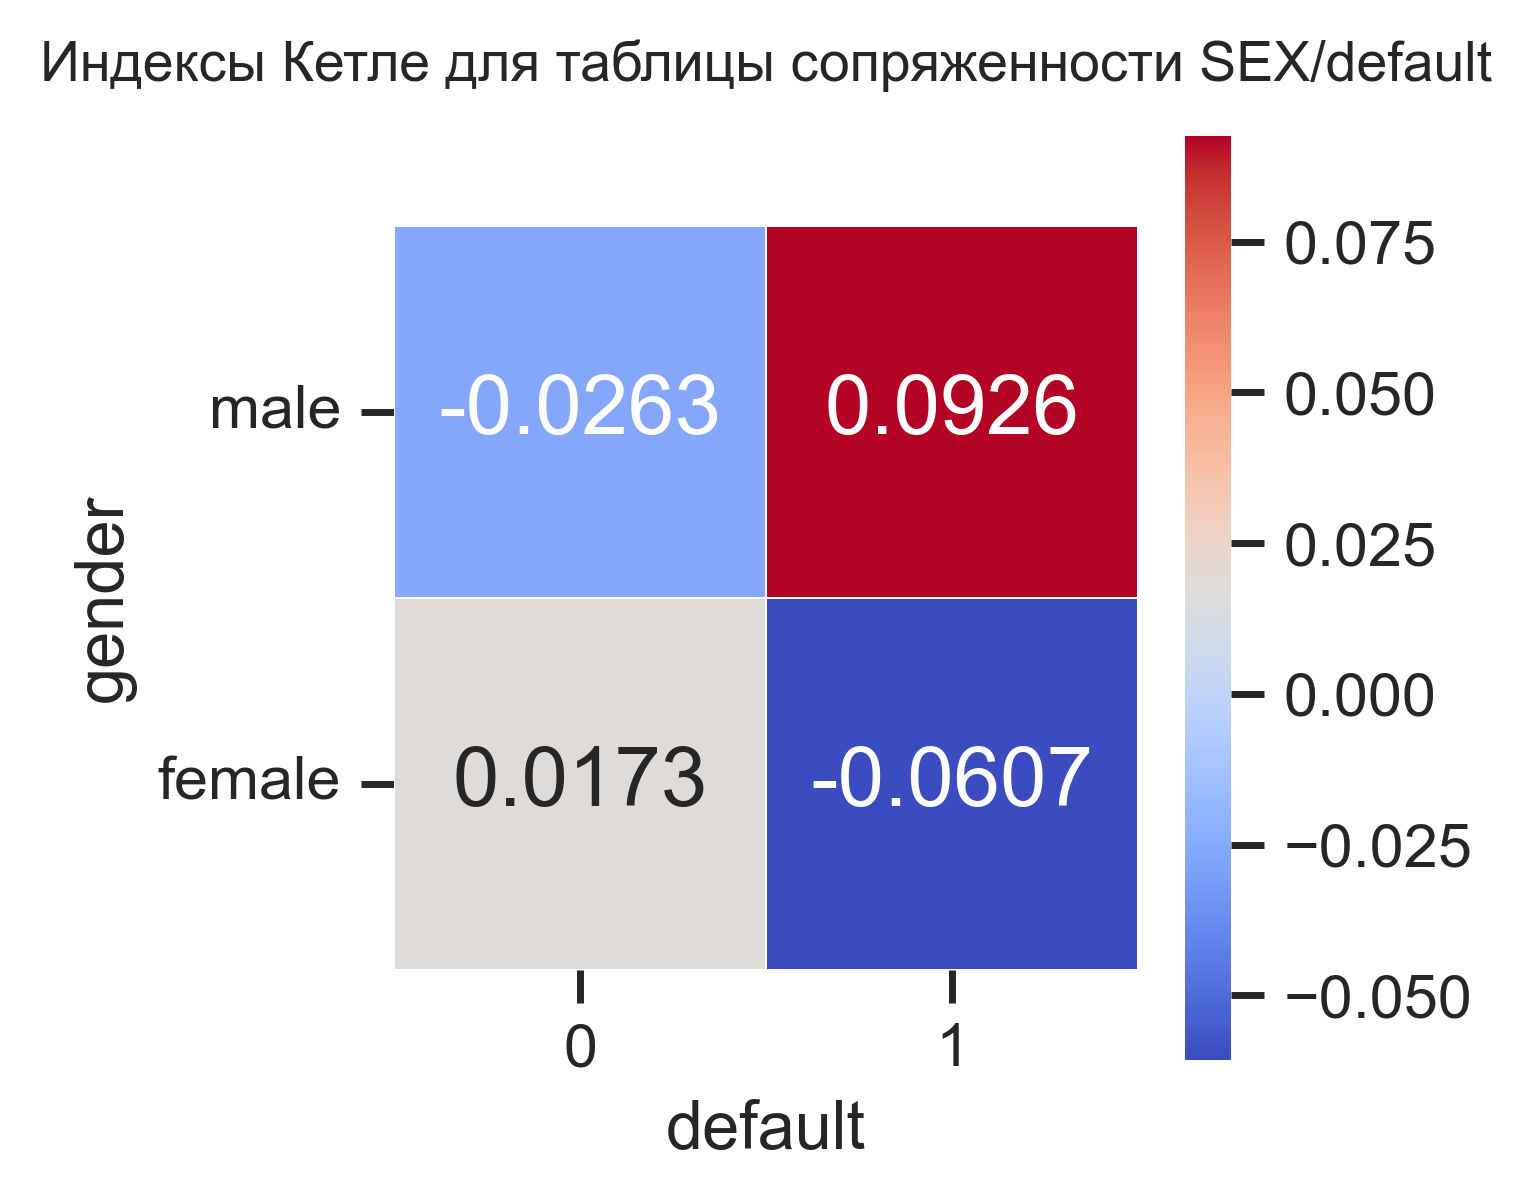

In [41]:
# тепловая карта индексов Кетле для таблицы сопряженности SEX/default
plt.figure(figsize=(3,3))
sns.heatmap(
    qtable, annot=True, fmt='.4f', annot_kws=dict(size=15),
    linewidths=0.3, square=True, cmap='coolwarm'
)
plt.yticks(rotation=0)
plt.title(title, size=10, y=1.15)
plt.show()

In [42]:
# ненормированный коэффициент хи-квадрат Пирсона
chi2 = (qtable * table.values).sum().sum()
chi2

47.90543311658061

Критерий хи-квадрат:

[__scipy.stats.chi2_contingency__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy-stats-chi2-contingency)

>Chi-square test of independence of variables in a contingency table.<br>
This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table _observed_. The expected frequencies are computed based on the marginal sums under the assumption of independence.

In [43]:
chi2_test = stats.chi2_contingency(table, correction=False)
print_black(chi2_test)

Chi2ContingencyResult(
    statistic=47.90543311657916,
    pvalue=4.472804335813844e-12,
    dof=1,
    expected_freq=array([[9258.3744, 2629.6256], [14105.6256, 4006.3744]]),
)



In [44]:
chi2_test.pvalue < ALPHA

True

In [45]:
np.isclose(chi2, chi2_test.statistic)

True

In [46]:
chi2 / 30_000

0.001596847770552687

Критерий хи-квадрат уверенно отклоняет гипотезу о независимости `SEX` и `default` на уровне доверия $95\%$, однако средняя связь между ними слабая: _средний_ прирост вероятности категорий одного признака, когда значение второго признака становится известным составляет лишь $\approx 0.16\%$.

Условие _заемщик — мужчина_ повышает частоту категории _невозврат кредита_ на $9.26\%$ по сравнению со средней. Условие _заемщик — женщина_ понижает частоту категории _невозврат кредита_ на $6.07\%$ по сравнению со средней.

***
### <a id='toc1_7_2_'></a>[__Сравнение гендерного состава подгрупп `default`__](#toc0_)

Проверим гипотезу о том, что гендерный состав подгрупп людей вернувших и не вернувших кредит отличается.

***
#### <a id='toc1_7_2_1_'></a>[__Доверительный интервал для доли__](#toc0_)

Построим доверительные интервалы для долей мужчин в обеих подгруппах `default` двумя методами каждый:

`normal`:

$$\large \hat{p}\pm z_{1-\frac{\alpha}{2}} \sqrt{\frac{\hat{p}\left(1-\hat{p}\right)}{n}} \qquad \hat{p} = \frac{m}{n}$$

`wilson`:

$$\large \frac1{ 1 + \frac{z^2}{n} } \left( \hat{p} + \frac{z^2}{2n} \pm z \sqrt{ \frac{ \hat{p}\left(1-\hat{p}\right)}{n} + \frac{
z^2}{4n^2} } \right) \qquad z \equiv z_{1-\frac{\alpha}{2}}$$ 

[__statsmodels.stats.proportion.proportion_confint__](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportion_confint.html#statsmodels-stats-proportion-proportion-confint)

>Confidence interval for a binomial proportion

In [47]:
# очистка контейнера для сбора выборок
samples.clear()

# выборки SEX для обеих подгрупп default
for default in (0, 1):
    sample = data.query(f'default == {default}').SEX
    
    # метка default и переменная датасета-источник выборки 
    # сохраняются в словаре атрибутов sample, объекте pd.Series
    sample.attrs['feature'] = 'SEX'
    sample.attrs['default'] = default
    samples.append(sample)

In [48]:
@dataclasses.dataclass(repr=False, kw_only=True)
class ProportionConfidenceInterval(ConfidenceIntervalTemplate):
    """
    Доверительный интервал для доли.
    """
    label: int | str  # категория признака (например, SEX=1 - мужчины)
    method: str
    
    def __post_init__(self) -> None:
        # default и переменная датасета-источник выборки, хранящиеся 
        # в словаре атрибутов sample, если sample - объект pd.Series
        if hasattr(self.sample, 'attrs'):
            self.feature = self.sample.attrs.get('feature')
            self.default = self.sample.attrs.get('default')
        
        # подсчет числа объектов со значением признака self.label
        count = (
            (self.sample == self.label).sum()
            if isinstance(self.sample, (np.ndarray, pd.Series))
            else self.sample.count(self.label)
        )
        
        # границы доверительного интервала уровня доверия 1 - self.alpha
        self.lower, self.upper = proportion_confint(
            count, len(self.sample), self.alpha, self.method
        ) 

См. также `proportion_ci` в [__scipy.stats.binomtest__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html#scipy-stats-binomtest).

Построение доверительных интервалов для всех пар значений метода и метки `default`:

In [49]:
methods = ['normal', 'wilson']

In [50]:
normal0, normal1, wilson0, wilson1 = [
    ProportionConfidenceInterval(sample, label=1, method=method)
    for method, sample in itertools.product(methods, samples)
]

__Ни для одного из двух методов доверительные интервалы для доли мужчин в подгруппах `default` не пересекаются__:

In [51]:
normal0.is_overlapping(normal1)

False

In [52]:
wilson0.is_overlapping(wilson1)

False

In [53]:
# сами доверительные интервалы
normal0, normal1, wilson0, wilson1

({
     "alpha": 0.05,
     "label": 1,
     "method": "normal",
     "feature": "SEX",
     "default": 0,
     "lower": 0.37960806572767264,
     "upper": 0.3920919856333957,
 },
 {
     "alpha": 0.05,
     "label": 1,
     "method": "normal",
     "feature": "SEX",
     "default": 1,
     "lower": 0.4210202357094044,
     "upper": 0.44486282637618935,
 },
 {
     "alpha": 0.05,
     "label": 1,
     "method": "wilson",
     "feature": "SEX",
     "default": 0,
     "lower": 0.3796273158089251,
     "upper": 0.392110265969876,
 },
 {
     "alpha": 0.05,
     "label": 1,
     "method": "wilson",
     "feature": "SEX",
     "default": 1,
     "lower": 0.421062418034934,
     "upper": 0.4448982369717182,
 })

***
#### <a id='toc1_7_2_2_'></a>[__Доверительный интервал для разности долей независимых выборок__](#toc0_)

$$\large \hat{p}_1 - \hat{p}_2 \pm z_{1-\frac{\alpha}{2}}\sqrt{\frac{\hat{p}_1(1 - \hat{p}_1)}{n_1} + \frac{\hat{p}_2(1 - \hat{p}_2)}{n_2}} \qquad \hat{p}_i = \frac{m_i}{n_i},\;i = 1,2$$

In [54]:
def confint_prop_diff_ind(
    sample1: array_like, sample2: array_like, alpha: float = ALPHA
) -> tuple[float, float]:
    """
    Доверительный интервал для разности долей независимых выборок.
    """
    z = stats.norm.ppf(1 - alpha/2)  # квантиль N(0,1) уровня 1 - a/2
    samples, funcs = (sample1, sample2), (np.mean, len)
    means, sizes = [tuple(map(f, samples)) for f in funcs]
    half = z * np.sqrt(sum(p*(1 - p)/n for p, n in zip(means, sizes)))
    return tuple(np.subtract(*means) + j*half for j in (-1, 1))

Мужчины в данных закодированы единицей, женщины двойкой. Чтобы рассчитывать долю как среднее (например, с помощью `numpy.mean`), необходимо привести метки к `0`/`1`. Вычтя из оригинальных меток полов единицу, получим, что мужчинам соответствует `0`, женщинам — `1`. Соответственно, построенный $1 - \alpha = 0.95$-доверительный интервал для разности долей будет для разности долей женщин:

In [55]:
samples = [data.query(f'default == {default}').SEX - 1 for default in (0, 1)]
confint_prop_diff_ind(*samples)

(0.03363493274962867, 0.060548077974896725)

__Построенный $0.95$-доверительный интервал для разности долей женщин в подгруппах `default` не содержит нуля__.

***
#### <a id='toc1_7_2_3_'></a>[__z-критерий для разности долей в независимых выборках__](#toc0_)

$H_0$: Доли в выборках равны, или, эквивалентно, разность долей в выборках равна нулю.

Статистика:

$$\large z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{P(1 - P)\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}} \sim \mathsf{N}(0,1) \qquad P = \frac{\hat{p}_1{n_1} + \hat{p}_2{n_2}}{{n_1} + {n_2}}$$

In [56]:
def zstat_prop_diff_ind(sample1: array_like, sample2: array_like) -> float:
    """
    z-статистика для разности долей независимых выборок. 
    """
    samples, funcs = (sample1, sample2), (np.mean, len)
    means, sizes = [np.array(list(map(f, samples))) for f in funcs]
    p = means @ sizes / np.sum(sizes)
    return np.subtract(*means) / np.sqrt(p*(1 - p) * np.sum(1/sizes))

In [57]:
def ztest_pvalue(zstat: float, alternative: str ='two-sided') -> float:
    """
    Достигаемый уровень значимости (pvalue) в z-тесте.
    """
    valid_alternatives = ['two-sided', 'less', 'greater']
    if alternative not in valid_alternatives:
        raise ValueError(
            'alternative must be one of '
            + ', '.join(map(repr, valid_alternatives))
        )
    resolver = {
        'less': stats.norm.cdf(zstat),
        'greater': stats.norm.sf(zstat),
        'two-sided': 2 * stats.norm.sf(np.abs(zstat))
    }
    return resolver[alternative]

In [58]:
ztest_pvalue(zstat_prop_diff_ind(*samples))

4.472804335814113e-12

__Нулевая гипотеза о равенстве нулю разности долей женщин в подгруппах `default` на уровне значимости `ALPHA` отклоняется__.

***
#### <a id='toc1_7_2_4_'></a>[__Биномиальный тест__](#toc0_)

Проверим гипотезу о том, что среди клиентов, $(a)$ вернувших кредит, $(b)$ не вернувших кредит, мужчины и женщины встречаются равновероятно, с помощью биномиального теста.

[__scipy.stats.binomtest__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html#scipy-stats-binomtest)

>Perform a test that the probability of success is _p_.<br>
The binomial test is a test of the null hypothesis that the probability of success in a Bernoulli experiment is _p_.

In [59]:
# векторизация функции stats.binomtest
binomtest = np.vectorize(stats.binomtest)

In [60]:
# случаи (a) и (b) последовательно:
print_black(binomtest(
    k=table.loc['male'], 
    n=table.sum(axis=0),
    # p=0.5 по умолчанию
)) 

array(
    [
        BinomTestResult(
            k=9015,
            n=23364,
            alternative="two-sided",
            statistic=0.38585002568053417,
            pvalue=4.8083898000919024e-269,
        ),
        BinomTestResult(
            k=2873,
            n=6636,
            alternative="two-sided",
            statistic=0.43294153104279687,
            pvalue=8.339736669031402e-28,
        ),
    ],
    dtype=object,
)



Гипотеза о том, что получить такое соотношение мужчин и женщин можно при параметре $p = 0.5$ биномиального распределения на уровне значимости `ALPHA` отклоняется для обеих подгрупп `default`. В контексте изучения гендерного состава подгрупп `default` примечательно огромное расхождение в порядках достигнутых `pvalue`: __тест оценивает подгруппу благонадежных плательщиков как значительно более гендерно ассиметричную__.

***
### <a id='toc1_7_3_'></a>[__Выводы__](#toc0_)

Анализ связей между `SEX` и `default` показал, что

* Критерий хи-квадрат уверенно отклоняет гипотезу о независимости `SEX` и `default` на уровне доверия $95\%$, однако средняя связь между ними слабая: _средний_ прирост вероятности категорий одного признака, когда значение второго признака становится известным составляет лишь $\approx 0.16\%$.
* Условие _заемщик — мужчина_ повышает частоту категории _невозврат кредита_ на $9.26\%$ по сравнению со средней. 
* Условие _заемщик — женщина_ понижает частоту категории _невозврат кредита_ на $6.07\%$ по сравнению со средней.

Гипотеза о том, что гендерный состав подгрупп людей вернувших и не вернувших кредит отличается, нашла свое подтверждение:

* Доверительные интервалы для доли мужчин в подгруппах `default` не пересекаются.
* Доверительный интервал для разности долей женщин в подгруппах `default` не содержит нуля.
* Гипотеза о равенстве нулю разности долей женщин в подгруппах `default` отклоняется.
* Биномиальный тест оценивает подгруппу благонадежных плательщиков как значительно более гендерно ассиметричную.

***
## <a id='toc1_8_'></a>[__Влияние уровня образования `EDUCATION`__](#toc0_)

Проверим гипотезу о том, что уровень образования не влияет на то, вернет ли клиент долг.

***
### <a id='toc1_8_1_'></a>[__Исследование связей с помощью индекса Кетле__](#toc0_)

In [61]:
# ненормализованная таблица сопряженности EDUCATION/default
# с маргинальными полями 
table_marg = pd.crosstab(data.EDUCATION, data.default, margins=True)
table_marg

default,0,1,All
EDUCATION,,,
0,14,0,14
1,8549,2036,10585
2,10700,3330,14030
3,3680,1237,4917
4,116,7,123
5,262,18,280
6,43,8,51
All,23364,6636,30000


In [62]:
# нормализованная таблица сопряженности EDUCATION/default 
# с маргинальными полями 
table_norm_marg = pd.crosstab(
    data.EDUCATION, data.default, 
    margins=True, normalize=True
)
table_norm_marg

default,0,1,All
EDUCATION,,,
0,0.000467,0.000000,0.000467
1,0.284967,0.067867,0.352833
2,0.356667,0.111000,0.467667
3,0.122667,0.041233,0.163900
4,0.003867,0.000233,0.004100
5,0.008733,0.000600,0.009333
6,0.001433,0.000267,0.001700
All,0.778800,0.221200,1.000000


Дальнейшие рассуждения будем вести на примере клиентов, не вернувших кредит, с уровнем образования `3` — выпускник школы.

Частота совместного появления этих категорий — значение на пересечении соответствующих строки и столбца, $1237 / 30000 \approx 4.12\%$ (частота совместного 
появления). В целом доля строки _выпускник школы_ — $16.39\%$. Значит, частота категории _невозврат кредита_ при условии _заемщик — выпускник школы_, равна $0.041233 / 0.1639 \approx 0.2516 = 25.16\%$.

Это много или мало? Трудно сказать, если не сравнить данное значение с безусловной 
вероятностью — частотой появления категории _невозврат кредита_ на всем множестве 
данных, равной $22.12\%$. Посчитаем относительную разницу
между условной и безусловной вероятностями, которая называется __индексом
Кетле__:

$$\large q(\texttt{default} = 1 \; | \; \texttt{EDUCATION} = 3) = \frac{0.2516 - 0.2212}{0.2212} \approx 0.1373 = 13.73\%.$$

Это значит, что условие _заемщик — выпускник школы_ повышает частоту категории _невозврат кредита_ на $13.73\%$ по сравнению со средней. Индекс Кетле показывает, на сколько процентов условная вероятность строки в таблице сопряженности отличается от ее безусловной вероятности; чем он больше, тем выше связь номинальных/категориальных признаков. __Обратим внимание, что индекс Кетле сравнивает условную вероятность
категории с безусловной, а не с той, которая получается при противоположном
условии__.

In [63]:
def quetelet_index(crosstab: pd.DataFrame) -> np.ndarray:
    """
    Индексы Кетле для ненормализованной таблицы частот
    без маргинальных полей.
    """
    values = crosstab.values
    values = values / values.sum()
    mrow, mcol = stats.contingency.margins(values)
    return (values / mrow - mcol) / mcol

In [64]:
# та же таблица сопряженности EDUCATION/default,
# ненормализованная и без маргинальных полей
table = pd.crosstab(data.EDUCATION, data.default)

index = [
    'доктор', 'магистр', 'бакалавр', 'выпускник школы', 
    'начальное образование', 'прочее', 'нет данных'
]

qtable = quetelet_index(table)
qtable = pd.DataFrame(qtable, index, columns=[0, 1])
qtable.index.name = 'EDUCATION'
qtable.columns.name = 'default'

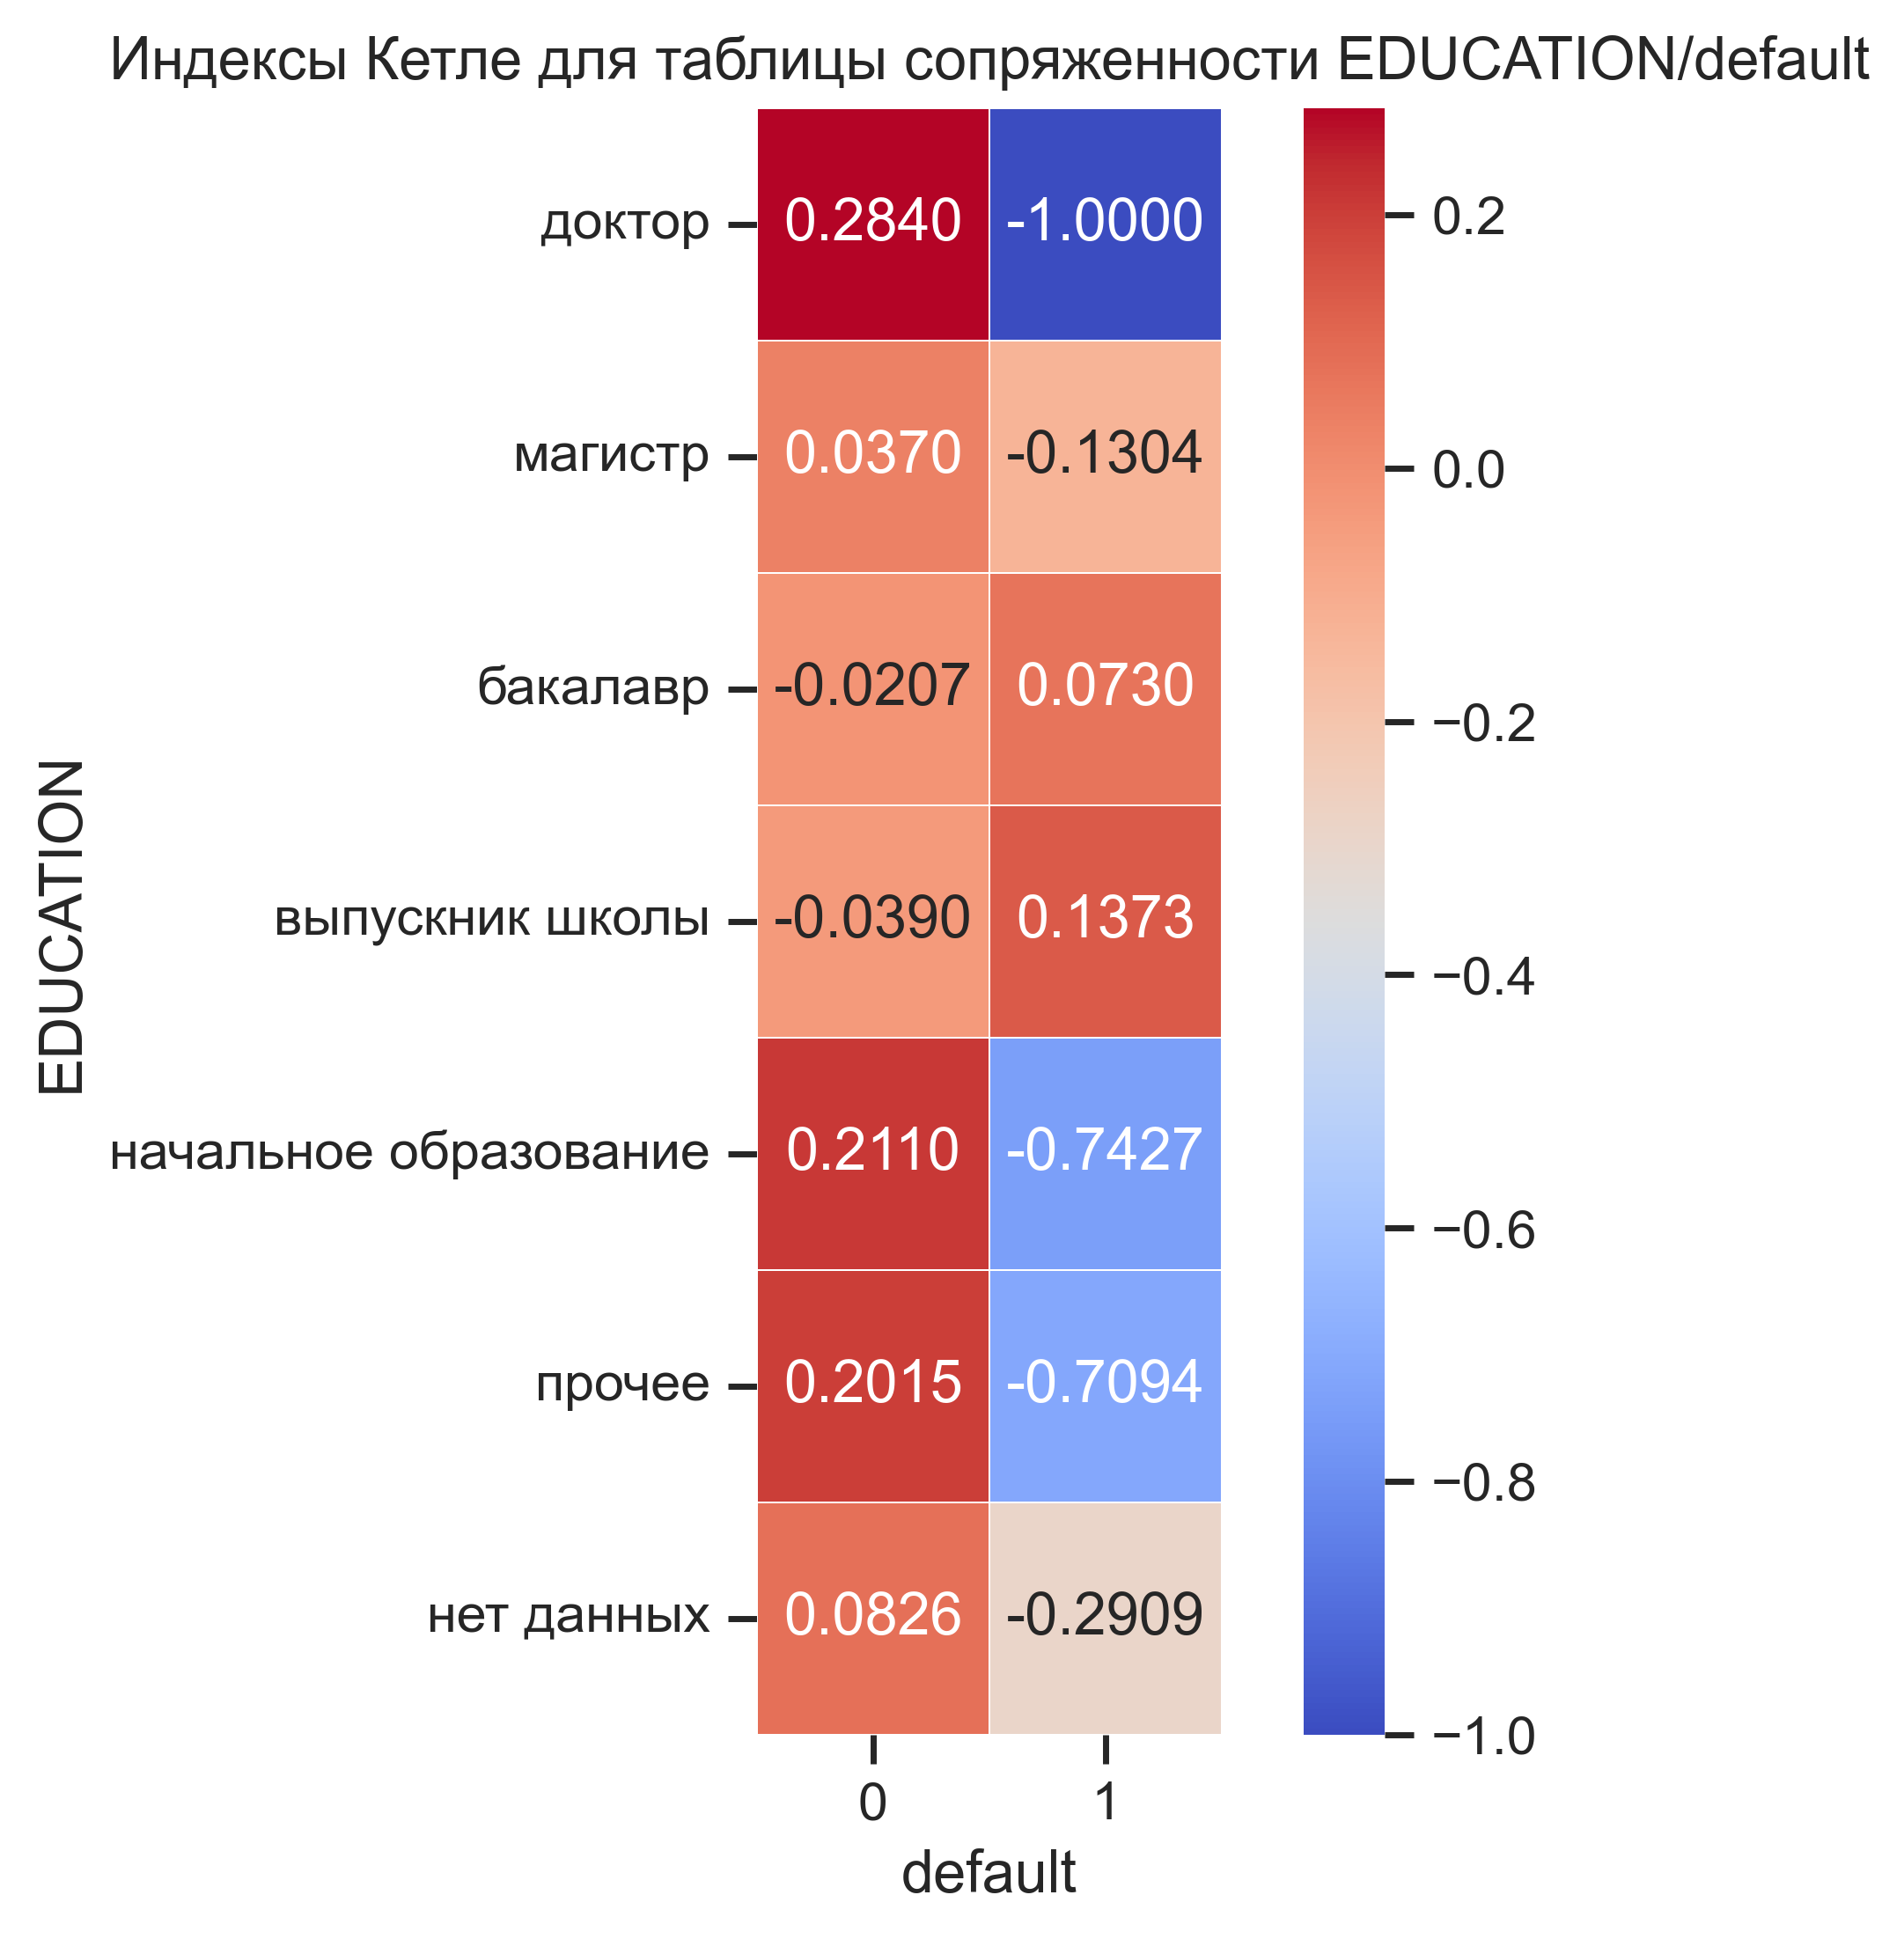

In [65]:
# тепловая карта индексов Кетле для таблицы сопряженности EDUCATION/default
plt.figure(figsize=(6,6))
sns.heatmap(
    qtable, annot=True, fmt='.4f', 
    linewidths=0.3, square=True, cmap='coolwarm'
)
plt.yticks(rotation=0)
plt.title('Индексы Кетле для таблицы сопряженности EDUCATION/default')
plt.show()

Из гипотезы независимости категорий ожидалось, что среди невернувших кредит будет $\approx 1088$ выпускников школ:

In [66]:
stats.contingency.expected_freq(table)

array([[1.0903200e+01, 3.0968000e+00],
       [8.2435980e+03, 2.3414020e+03],
       [1.0926564e+04, 3.1034360e+03],
       [3.8293596e+03, 1.0876404e+03],
       [9.5792400e+01, 2.7207600e+01],
       [2.1806400e+02, 6.1936000e+01],
       [3.9718800e+01, 1.1281200e+01]])

In [67]:
# ожидаемые частоты своими руками
np.multiply(*stats.contingency.margins(table)) / table.values.sum()

array([[1.0903200e+01, 3.0968000e+00],
       [8.2435980e+03, 2.3414020e+03],
       [1.0926564e+04, 3.1034360e+03],
       [3.8293596e+03, 1.0876404e+03],
       [9.5792400e+01, 2.7207600e+01],
       [2.1806400e+02, 6.1936000e+01],
       [3.9718800e+01, 1.1281200e+01]])

Фактически же их $1237$:

In [68]:
table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Таким образом прирост относительно ожидаемого среднего составил $\approx 13.73\%$:

In [69]:
(1237 - 1087.6404) / 1087.6404

0.13732443186185433

Умножим коэффициенты Кетле на абсолютные частоты значений в соответствующих
ячейках. При этом следует выражать коэффициенты Кетле в абсолютных 
величинах, а не в процентах. В результате получаем таблицу, элементы которой
суммируются к $\approx 163.22$ — ненормированному коэффициенту хи-квадрат Пирсона:

In [70]:
chi2 = (qtable.values * table).sum().sum()
chi2

163.21655786997007

Критерий хи-квадрат:

[__scipy.stats.chi2_contingency__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy-stats-chi2-contingency)

>Chi-square test of independence of variables in a contingency table.<br>
This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table _observed_. The expected frequencies are computed based on the marginal sums under the assumption of independence.

In [71]:
chi2_test = stats.chi2_contingency(table)
print_black(chi2_test)

Chi2ContingencyResult(
    statistic=163.21655786997073,
    pvalue=1.2332626245415605e-32,
    dof=6,
    expected_freq=array(
        [
            [1.0903200e01, 3.0968000e00],
            [8.2435980e03, 2.3414020e03],
            [1.0926564e04, 3.1034360e03],
            [3.8293596e03, 1.0876404e03],
            [9.5792400e01, 2.7207600e01],
            [2.1806400e02, 6.1936000e01],
            [3.9718800e01, 1.1281200e01],
        ]
    ),
)



In [72]:
np.isclose(chi2, chi2_test.statistic)

True

In [73]:
chi2_test.pvalue < ALPHA

True

Будучи нормированной общим числом наблюдений, эта величина характеризует средний прирост вероятности категорий одного признака, когда значение второго признака становится известным, — на $\approx 0.54\%$:

In [74]:
chi2 / 30_000

0.005440551928999003

Тот же результат можно получить, переставив суммирование и нормировку местами: умножить коэффициенты Кетле на _относительные_ частоты, затем просуммировать: 

In [75]:
table_norm = pd.crosstab(data.EDUCATION, data.default, normalize=True)
(qtable.values * table_norm).sum().sum()

0.005440551928999001

***
### <a id='toc1_8_2_'></a>[__Выводы__](#toc0_)

* Гипотеза о том, что уровень образования не влияет на то, вернет ли клиент долг, не нашла свое подтверждение. Критерий хи-квадрат уверенно отклоняет гипотезу о независимости `EDUCATION` и `default` на уровне доверия $95\%$, однако средняя связь между ними слабая: _средний_ прирост вероятности категорий одного признака, когда значение второго признака становится известным составляет лишь $0.54\%$.

* Наиболее тревожным, с точки зрения `default`, значением признака `EDUCATION` является значение _выпускник школы_: (см. тепловую карту индексов Кетле) реализация `EDUCATION=3` повышает частоту реализации `default=1` на $13.73\%$ по сравнению со средней.

* Наиболее оптимистичным значением признака `EDUCATION` — индикатором того, что клиент вернет кредит, является значение _доктор_: ни один из $14$ заемщиков-докторов наук не обманул ожиданий банка. Коэффициент Кетле для данной категории `EDUCATION` равен $-1$, что означает стопроцентный возврат кредита. Имеет место наибольшая связь — __концептуальная__ (логическая). Концептуальная связь усматривается тогда, когда в строке $k$ все немаргинальные величины, кроме одной, скажем, в столбце $l$, равны $0$, что означает, что если объект имеет категорию $k$ первого признака, он заведомо будет иметь категорию $l$ второго признака. Это означает логическую импликацию, или концептуальную связь.

***
## <a id='toc1_9_'></a>[__Влияние семейного положения `MARRIAGE`__](#toc0_)

***
### <a id='toc1_9_1_'></a>[__Исследование связей с помощью индекса Кетле__](#toc0_)

Индекс Кетле показывает, на сколько процентов условная вероятность строки в таблице сопряженности отличается от ее безусловной вероятности; чем он больше, тем выше связь номинальных/категориальных признаков. 

Подробное объяснение индексов Кетле и их связи с коэффициентом хи-квадрат Пирсона дано выше на примере другой пары признаков. Применим индексы Кетле для анализа и интерпретации связи семейного положения клиента `MARRIAGE` и индикатора невозврата кредита `default`.

In [76]:
def quetelet_index(crosstab: pd.DataFrame) -> np.ndarray:
    """
    Индексы Кетле для ненормализованной таблицы частот
    без маргинальных полей.
    """
    values = crosstab.values
    values = values / values.sum()
    mrow, mcol = stats.contingency.margins(values)
    return (values / mrow - mcol) / mcol

In [77]:
# таблица сопряженности MARRIAGE/default
table = pd.crosstab(data.MARRIAGE, data.default)
table

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


In [78]:
# индексы Кетле для таблицы сопряженности MARRIAGE/default
qtable = quetelet_index(table)
index = ['отказываюсь отвечать', 'в браке', 'холост', 'нет данных']
qtable = pd.DataFrame(qtable, index, columns=[0, 1])
qtable.index.name = 'MARRIAGE'
qtable.columns.name = 'default'

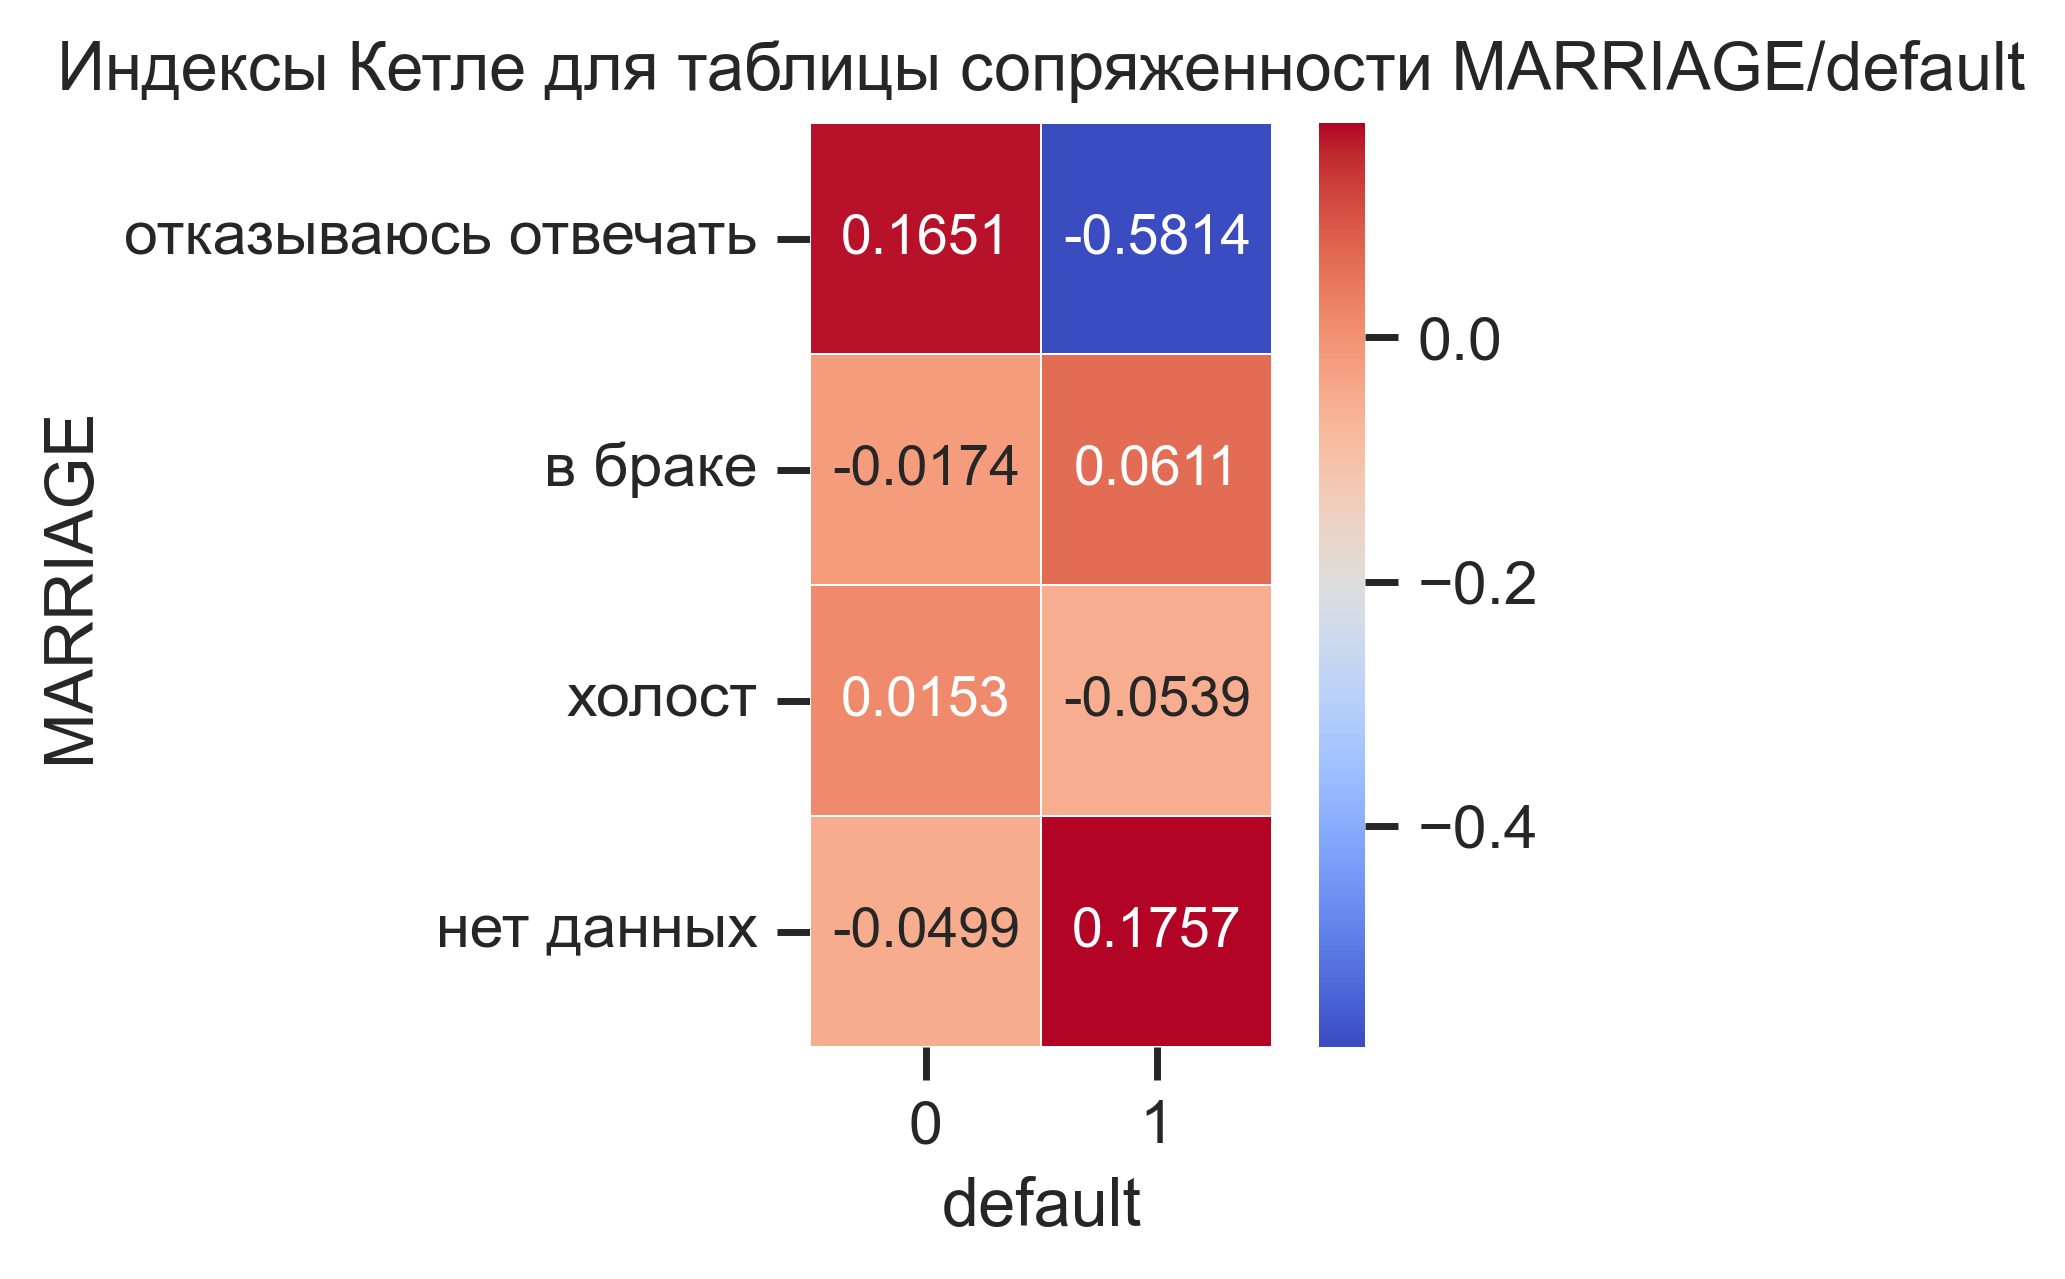

In [79]:
# тепловая карта индексов Кетле для таблицы сопряженности MARRIAGE/default
plt.figure(figsize=(3,3))
sns.heatmap(
    qtable, annot=True, fmt='.4f', annot_kws=dict(fontsize=10),
    linewidths=0.3, square=True, cmap='coolwarm'
)
plt.yticks(rotation=0)
plt.title('Индексы Кетле для таблицы сопряженности MARRIAGE/default')
plt.show()

In [80]:
# ненормированный коэффициент хи-квадрат Пирсона
chi2 = (qtable * table.values).sum().sum()
chi2

35.66239583433865

Критерий хи-квадрат:

[__scipy.stats.chi2_contingency__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html#scipy-stats-chi2-contingency)

>Chi-square test of independence of variables in a contingency table.<br>
This function computes the chi-square statistic and p-value for the hypothesis test of independence of the observed frequencies in the contingency table _observed_. The expected frequencies are computed based on the marginal sums under the assumption of independence.

In [81]:
chi2_test = stats.chi2_contingency(table)
print_black(chi2_test)

Chi2ContingencyResult(
    statistic=35.66239583433609,
    pvalue=8.825862457577375e-08,
    dof=3,
    expected_freq=array(
        [
            [4.20552000e01, 1.19448000e01],
            [1.06376292e04, 3.02137080e03],
            [1.24327632e04, 3.53123680e03],
            [2.51552400e02, 7.14476000e01],
        ]
    ),
)



In [82]:
chi2_test.pvalue < ALPHA

True

In [83]:
np.isclose(chi2, chi2_test.statistic)

True

In [84]:
chi2 / 30_000

0.0011887465278112885

***
### <a id='toc1_9_2_'></a>[__Выводы__](#toc0_)

Анализ связей между `MARRIAGE` и `default` показал, что

* Критерий хи-квадрат уверенно отклоняет гипотезу о независимости `MARRIAGE` и `default` на уровне доверия $95\%$, однако средняя связь между ними слабая: _средний_ прирост вероятности категорий одного признака, когда значение второго признака становится известным составляет лишь $\approx 0.12\%$.
* Отсутствие данных о семейном положении повышает частоту категории _невозврат кредита_ на $17.57\%$ по сравнению со средней.
* Активный ответ на вопрос о семейном положении _отказываюсь отвечать_ понижает частоту категории _невозврат кредита_ на $58.14\%$ по сравнению со средней.

Попробуем осторожно проинтерпретировать эти результаты. 

Можно предположить, что люди, отмечающие чекбокс _отказываюсь отвечать_, отказываются давать ответ не потому, что априори не собираются возвращать деньги, а просто ввиду чувствительного восприятия личных вопросов как вторжения в частную жизнь. Примерно так: "Я добросовестный заемщик, но не лезьте в мою жизнь". Вообще сам факт ответа "не дам ответ" говорит, во-первых, о контактности, нескрытности, педантичности человека, а значит, о непредрасположенности нарушать закон или обязательства; во-вторых, о том, что он как минимум состоит в незарегистрированных отношениях. _Отказываюсь отвечать_ в данном случае это что-то типа синонима того, что в социальных сетях обозначается как _все сложно_.

***
## <a id='toc1_10_'></a>[__Влияние возраста клиента `AGE`__](#toc0_)

***
### <a id='toc1_10_1_'></a>[__Описательные статистики. Распределение в разрезе `default`__](#toc0_)

In [85]:
# описательные статистики для AGE и default
# раскоментировать вторую строку для расширенной статистики

data[['AGE', 'default']].describe()
# describe(data[['AGE', 'default']])

,AGE,default
count,30000.000000,30000.000000
mean,35.485500,0.221200
std,9.217904,0.415062
min,21.000000,0.000000
25%,28.000000,0.000000
50%,34.000000,0.000000
75%,41.000000,0.000000
max,79.000000,1.000000


In [86]:
# контейнер для сбора выборок
samples = []

# выборки AGE для обеих подгрупп default
for default in (0, 1):
    sample = data.query(f'default == {default}').AGE
    
    # метка default сохраняется в словаре атрибутов sample, объекте pd.Series
    sample.attrs['default'] = default
    samples.append(sample)

In [87]:
# описательные статистики для AGE, подгруппа default=0
# раскоментировать вторую строку для расширенной статистики

samples[0].describe()
# describe(samples[0])

count    23364.000000
mean        35.417266
std          9.077355
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [88]:
# описательные статистики для AGE, подгруппа default=1
# раскоментировать вторую строку для расширенной статистики

samples[1].describe()
# describe(samples[1])

count    6636.000000
mean       35.725738
std         9.693438
min        21.000000
25%        28.000000
50%        34.000000
75%        42.000000
max        75.000000
Name: AGE, dtype: float64

In [89]:
# общая медиана выборок AGE для обеих подгрупп default
median = np.median(samples[0])

In [90]:
# заголовок графика и комментарий
title = 'Гистограмма распределения AGE в разрезе default'
comment = 'Ширина бина 5 лет'

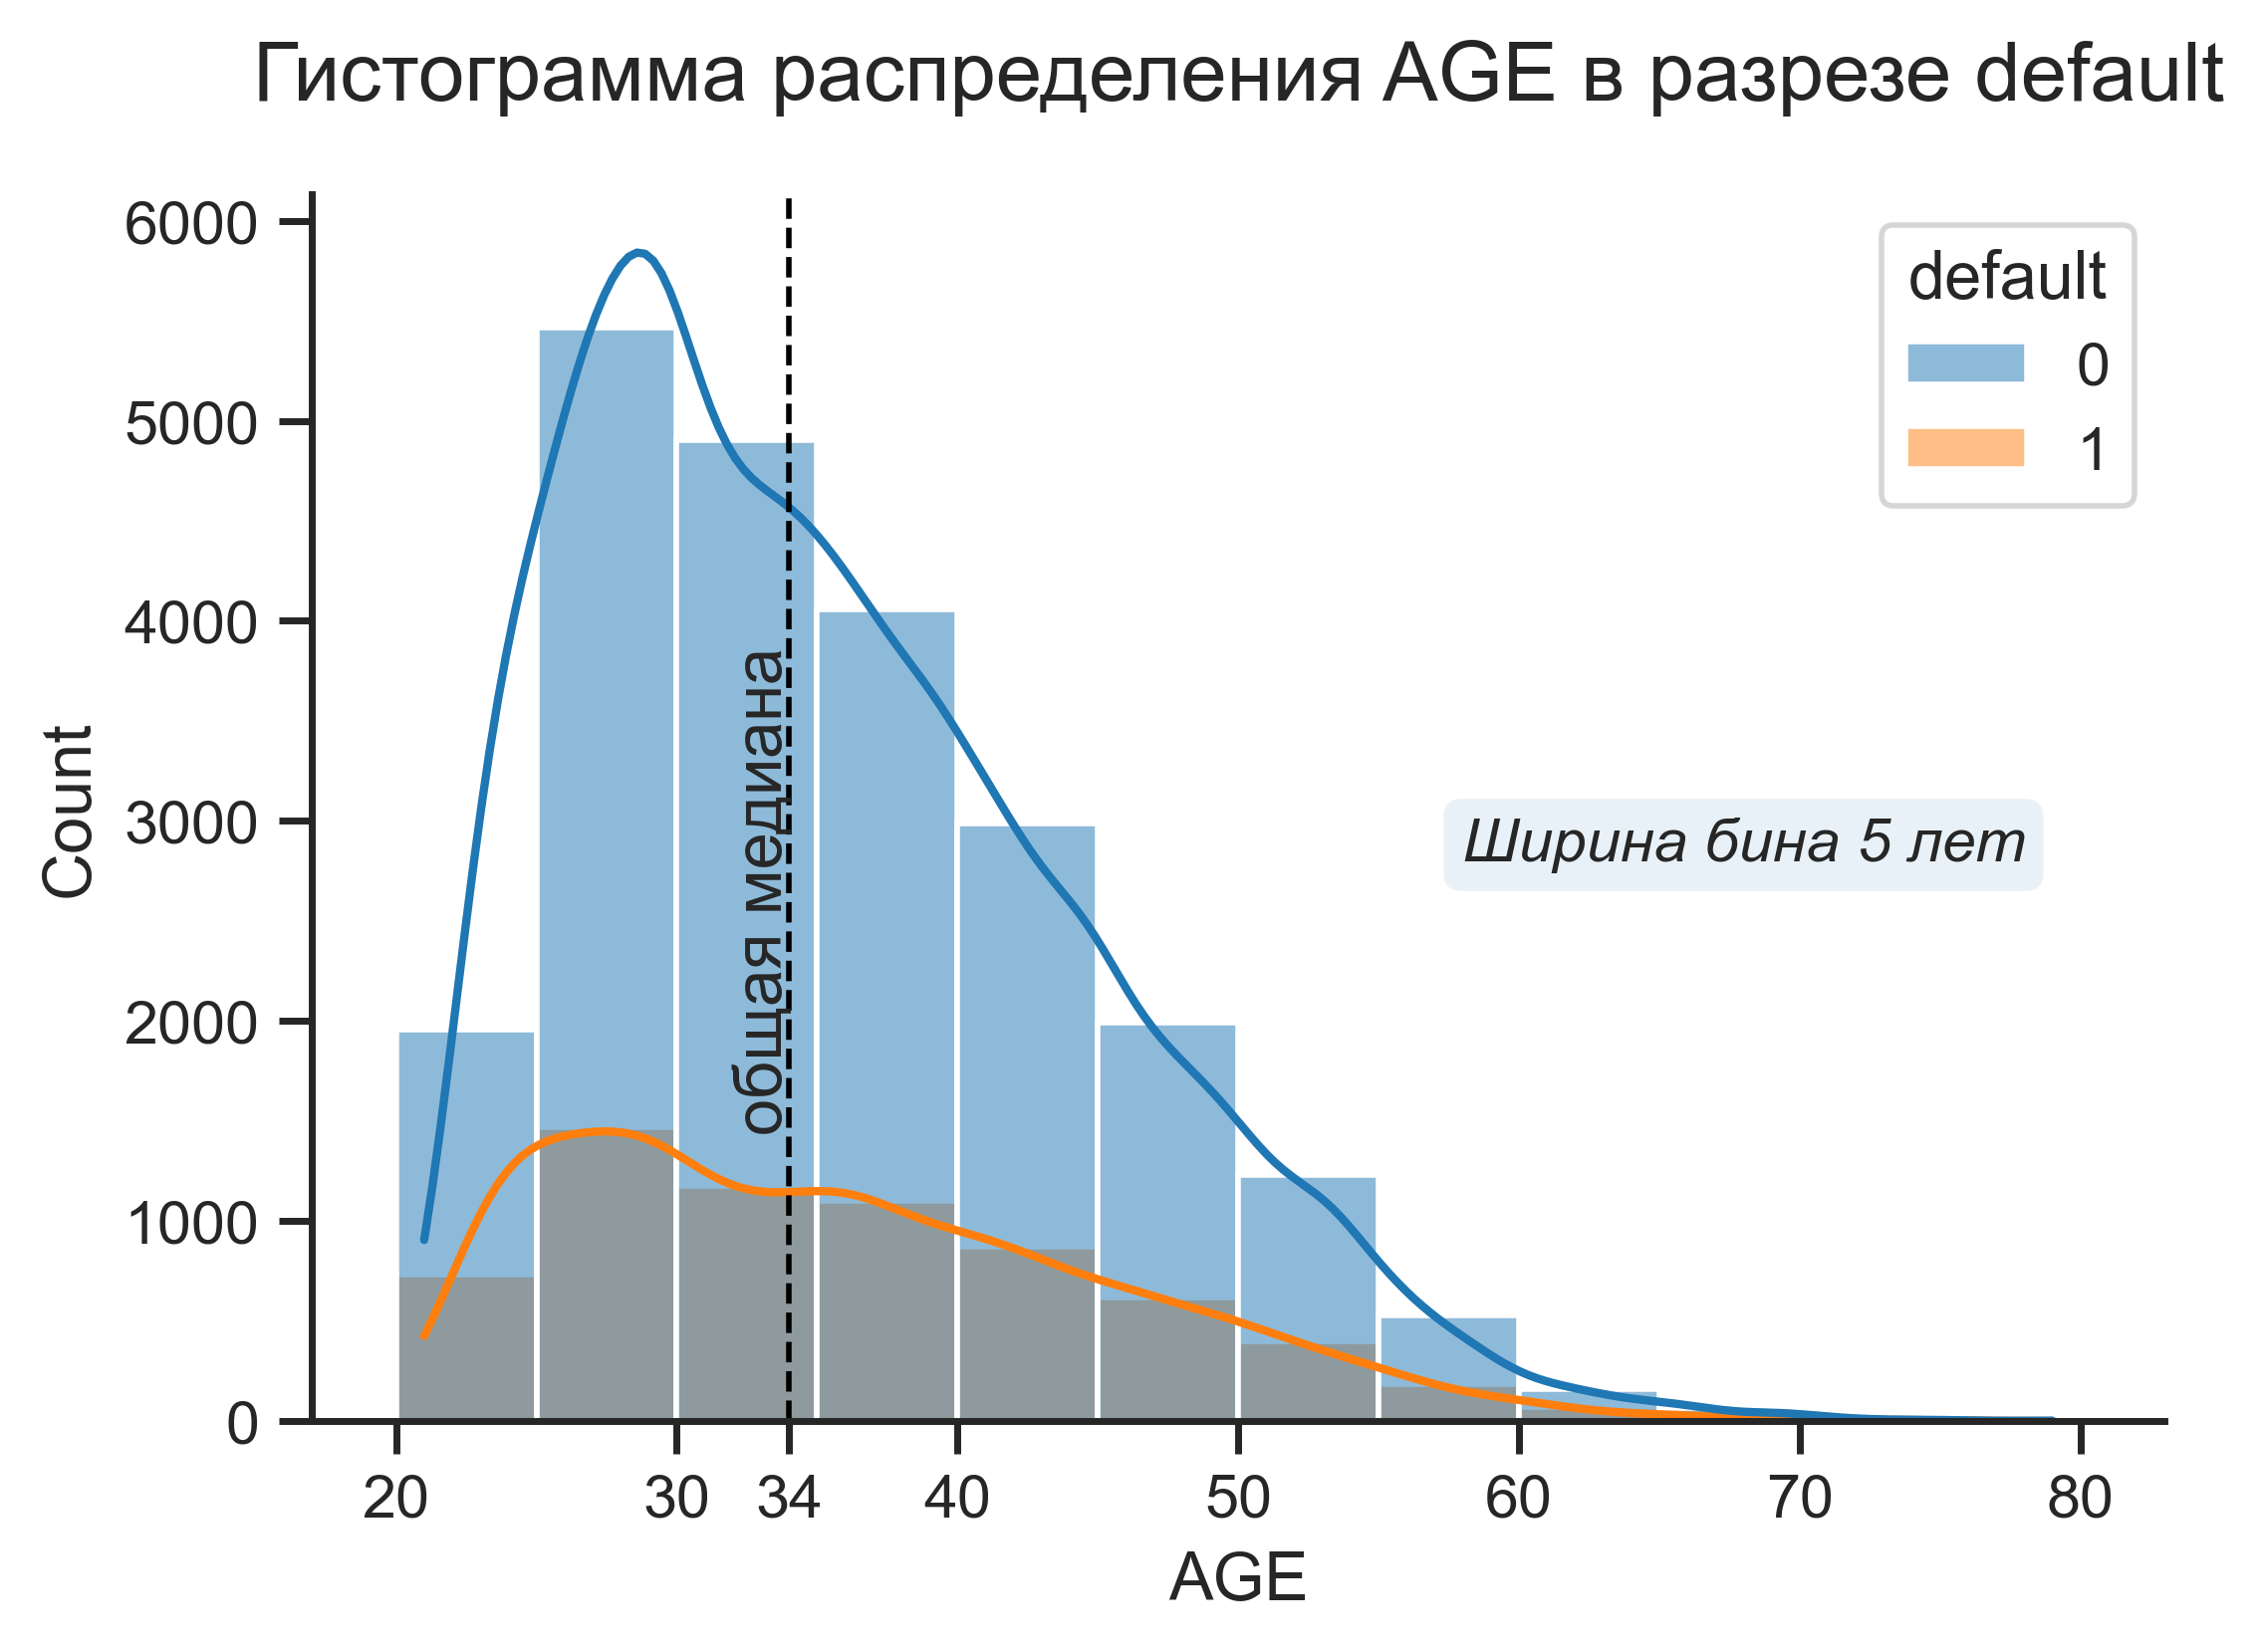

In [91]:
# гистограмма распределения AGE в разрезе default
plt.figure(figsize=(6,4))
sns.histplot(
    data, x='AGE', hue='default', 
    bins=12, binrange=(20, 80), kde=True
)
plt.axvline(median, c='k', ls='dashed', lw=1)
plt.annotate(
    comment, xy=(68, 2.8e3), fontsize=11, fontstyle='italic',
    bbox=dict(boxstyle='round', alpha=0.1), ha='center'
)
plt.xticks([*range(20, 90, 10), median])
plt.title(title, fontsize=15, y=1.05)
plt.annotate('общая медиана', xy=(median-2, 1500), rotation=90)
plt.show()

***
### <a id='toc1_10_2_'></a>[__Гипотеза о равенстве медиан. Критерий Краскела-Уоллиса. Медианный тест__](#toc0_)

Проверим гипотезу о равенстве медианных значений возраста клиента `AGE` в разрезе индикатора невозврата кредита `default` с помощью критерия Краскела-Уоллиса и медианного теста.

Критерий Краскела-Уоллиса:

[__scipy.stats.kruskal__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.kruskal.html#scipy-stats-kruskal)

>Compute the Kruskal-Wallis H-test for independent samples.<br>
The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal. It is a non-parametric version of ANOVA. The test works on 2 or more independent samples, which may have different sizes.

In [92]:
stats.kruskal(*samples)

KruskalResult(statistic=0.795297355578892, pvalue=0.3725031126820255)

__Гипотеза о равенстве медиан на уровне значимости `ALPHA` не отклонена.__

Медианный тест:

[__scipy.stats.median_test__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.median_test.html#scipy-stats-median-test)

>Perform a Mood’s median test.<br>
Test that two or more samples come from populations with the same median.
The _grand median_ of all the data is computed, and a contingency table is formed by classifying the values in each sample as being above or below the grand median. The contingency table [...] passed to scipy.stats.chi2_contingency to compute the test statistic and p-value.

>The contingency table. The shape of the table is (2, n), where n is the number of samples. The first row holds the counts of the values above the grand median, and the second row holds the counts of the values below the grand median.

In [93]:
print_black(stats.median_test(*samples))

MedianTestResult(
    statistic=7.827238064642474,
    pvalue=0.005146468081225634,
    median=34.0,
    table=array([[11039, 3265], [12325, 3371]], dtype=int64),
)



__Гипотеза о равенстве медиан на уровне значимости `ALPHA` не отклонена.__

***
### <a id='toc1_10_3_'></a>[__Гипотеза об общности порождающего распределения__](#toc0_)

***
#### <a id='toc1_10_3_1_'></a>[__Перестановочный тест__](#toc0_)

Проверим гипотезу об общности порождающего распределения для выборок `AGE`, соответствующих разным подгруппам `default` с помощью перестановочного теста для независимых выборок.

[__scipy.stats.permutation_test__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.permutation_test.html#scipy-stats-permutation-test)
>Performs a permutation test of a given statistic on provided data.<br>
For independent sample statistics, the null hypothesis is that the data are randomly sampled from the same distribution.

>__*statistic*__ callable <br>
>Statistic for which the p-value of the hypothesis test is to be calculated.

In [94]:
# функция, которая вызывается на выборки и формирует нулевое распределение
statistic = lambda x, y: np.mean(x) - np.mean(y)

In [95]:
# перестановочный тест
res = stats.permutation_test(samples, statistic, random_state=3)
print_black(res)

PermutationTestResult(
    statistic=-0.308472517494188,
    pvalue=0.0156,
    null_distribution=array(
        [0.01021223, -0.19585896, 0.13985326, ..., 0.08219203, -0.01416802, -0.2370732]
    ),
)



In [96]:
# величина статистики теста и нулевое распределение - 
# массив разностей средних случайных перестановок
stat, null = res.statistic, res.null_distribution

In [97]:
# как получается статистика теста
np.mean(samples[0]) - np.mean(samples[1]) == stat

True

По гистограмме ниже мы увидим, что нулевое распределение — нормальное. Оценим параметры этого нормального распределения, среднее и стандартное отклонение, с помощью метода максимального правдоподобия:

In [98]:
loc, scale = stats.norm.fit(null)
loc, scale

(0.0011216855432118209, 0.12791224064038306)

Инициализируем нормально распределенную случайную величину `Nfit` найденными параметрами:

In [99]:
Nfit = stats.norm(loc, scale)

Передадим функции распределения (_cumulative distribution function_) `Nfit` значение статистики теста и умножим на два, учитывая двусторонний характер нулевой гипотезы: 

In [100]:
Nfit.cdf(stat) * 2

0.015504971023291715

Полученное таким образом апроксимированное pvalue близко к истинному pvalue, найденному в тесте. Изобразим на одном графике гистограмму нулевого распределения и функцию плотности вероятности (_probability density function_) обученной на нем случайной величины `Nfit`.

In [101]:
# 0.025- и 0.975-квантили Nfit
quantiles = [Nfit.ppf(ALPHA/2), Nfit.ppf(1 - ALPHA/2)]

In [102]:
# массивы абсцисс для отрисовки элементов графика
x = np.linspace(-0.5, 0.5, 1000)

spaces = [
    np.linspace(-0.5, quantiles[0]), np.linspace(-0.5, stat),
    np.linspace(quantiles[1], 0.5), np.linspace(-stat, 0.5)
]

In [103]:
# заголовок графика и подпись к нулевому распределению
title = 'Гистограмма нулевого распределения и функция плотности вероятности Nfit'
label = 'Нулевое распределение'

In [104]:
# повторяющиеся параметры собраны в словари
hist = dict(x=null, bins=20, density=True)
arr = dict(arrowprops=dict(arrowstyle='-', lw=0.6, color='k'), fontsize=7)

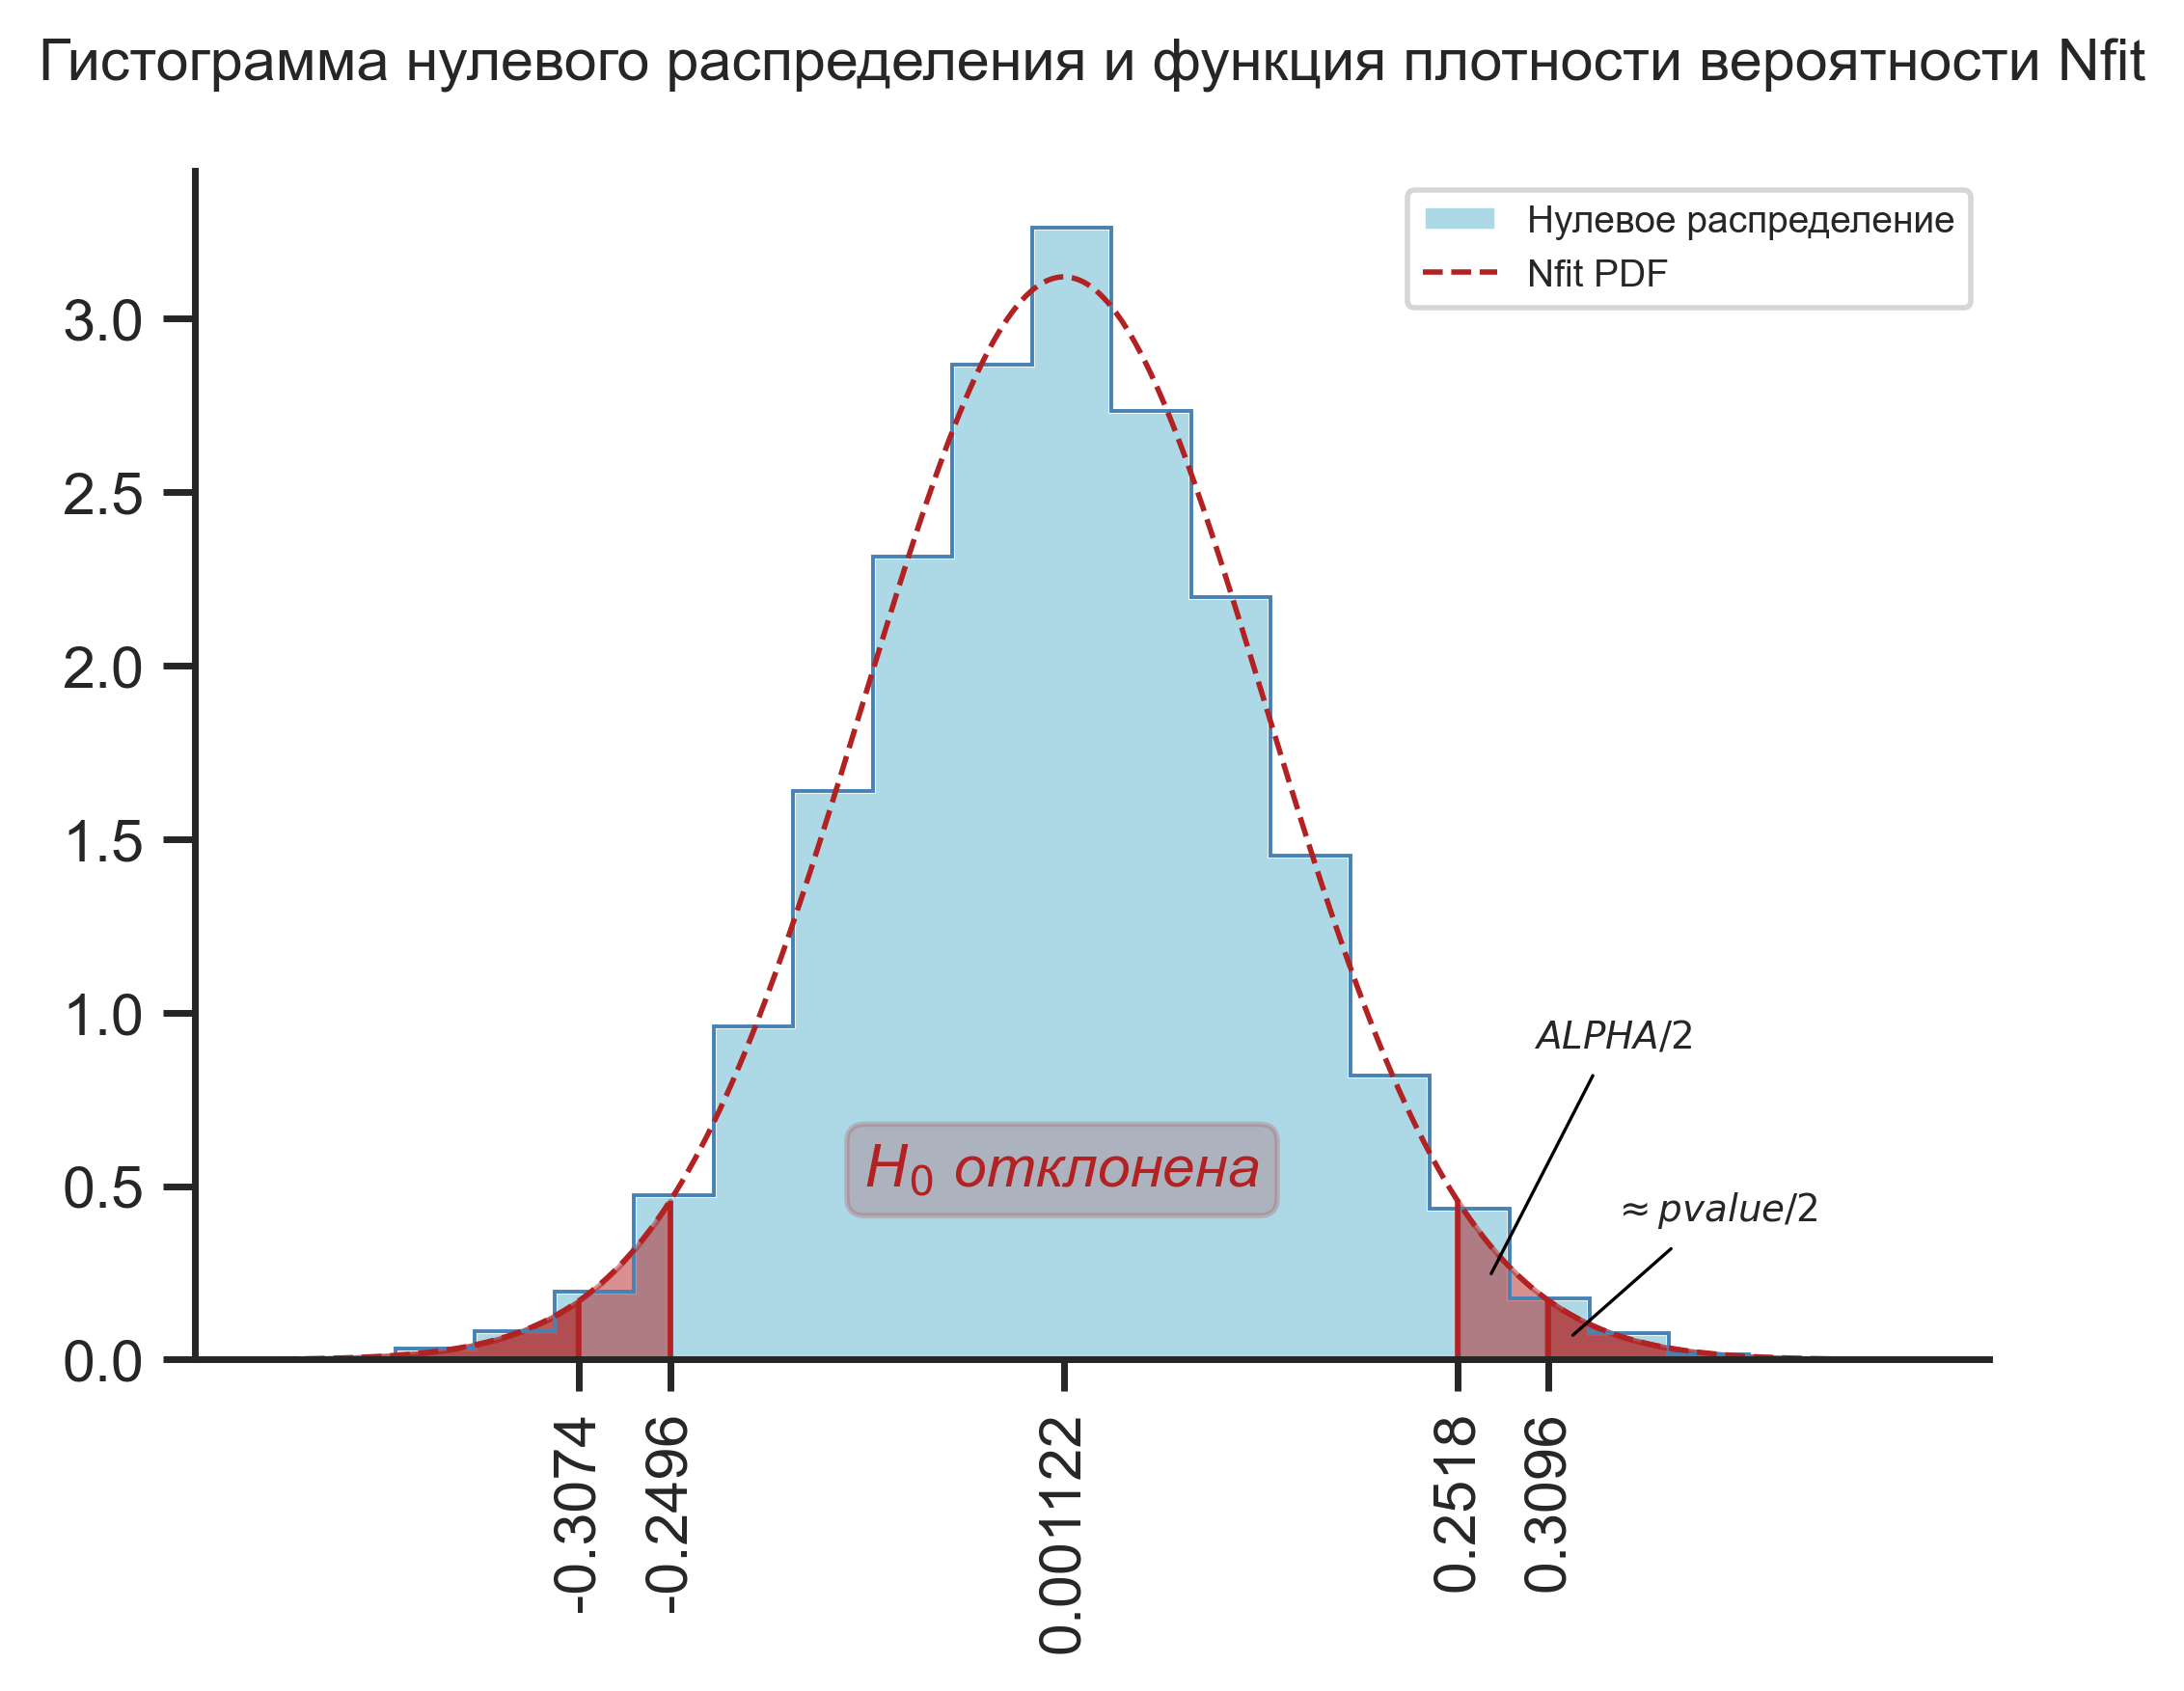

In [105]:
# гистограмма нулевого распределения и функция плотности вероятности Nfit
plt.figure(figsize=(6,4))

plt.hist(histtype='stepfilled', color='lightblue', label=label, **hist)
plt.hist(histtype='step', lw=0.7, color='steelblue', **hist)

plt.plot(x, Nfit.pdf(x), ls='--', label='Nfit PDF', lw=1, color='firebrick')
plt.vlines([loc+stat, loc-stat], 0, Nfit.pdf(stat), lw=1, colors='firebrick')
plt.vlines(quantiles, 0, Nfit.pdf(quantiles[0]), lw=1, colors='firebrick')

for space in spaces:
    plt.fill_between(space, Nfit.pdf(space), 0, color='firebrick', alpha=0.5)

plt.annotate('$ALPHA/2$', xy=(0.27, 0.22), xytext=(0.3, 0.9), **arr)
plt.annotate('$\\approx pvalue/2$', xy=(0.32, 0.05), xytext=(0.35, 0.4), **arr)
plt.annotate(
    '$H_0$ отклонена', xy=(0, 0.5), size=11, style='italic', c='firebrick',
    bbox=dict(boxstyle='round', color='firebrick', alpha=0.2), ha='center'
)

plt.xticks([loc, loc+stat, loc-stat, *quantiles], rotation=90)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.4g'))

plt.legend(fontsize=7)
plt.title(title, fontsize=11, y=1.05)
plt.show()

Если визуально кажется, что область на графике, соответствующая половине `ALPHA`, больше $2.5\%$, то это потому, что данное нормальное распределение _узкое_, — стандартное отклонение значительно меньше единицы:

In [106]:
scale

0.12791224064038306

Проверка правого хвоста:

In [107]:
Nfit.sf(Nfit.ppf(1 - ALPHA/2))  # survival function (1 - cdf)

0.025

Проверка интегрированием левого хвоста:

In [108]:
quad(Nfit.pdf, -np.inf, Nfit.ppf(ALPHA/2))[0]

0.02499999999999998

***
#### <a id='toc1_10_3_2_'></a>[__U-тест Манна-Уитни. Тест Колмогорова-Смирнова__](#toc0_)

Перестановочный тест на уровне значимости `ALPHA` отклонил гипотезу об общности распределения, порождающего выборки `AGE` в подгруппах `default`. Однако U-тест Манна-Уитни на том же уровне значимости уверенно отдает предпочтение нулевой гипотезе:

In [109]:
stats.mannwhitneyu(*samples)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.3725035434898616)

In [110]:
mannwhitneyu_statistic_handmade(*samples)

MWUHandmadeResult(statistic=76966879.5, h0_point=77521752.0)

Статистика теста лежит чуть левее `h0_point`, что означает, что выборка `AGE` подгруппы `default=1` локализована чуть правее выборки `AGE` подгруппы `default=0`. Однако тест голосует за то чтобы признать обе выборки реализацией одного распределения.

В качестве тайбрейка проведем тест Колмогорова-Смирнова:

[__scipy.stats.kstest__](https://docs.scipy.org/doc/scipy-1.11.3/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest)
>Performs the (one-sample or two-sample) Kolmogorov-Smirnov test for goodness of fit.<br>
The one-sample test compares the underlying distribution F(x) of a sample against a given distribution G(x). The two-sample test compares the underlying distributions of two independent samples. Both tests are valid only for continuous distributions.

In [111]:
print_black(stats.kstest(*samples))

KstestResult(
    statistic=0.03400364326131329,
    pvalue=1.2584243902803712e-05,
    statistic_location=25,
    statistic_sign=-1,
)



In [112]:
# заголовок графика
title = 'Эмпирические функции распределения AGE в подгруппах default'

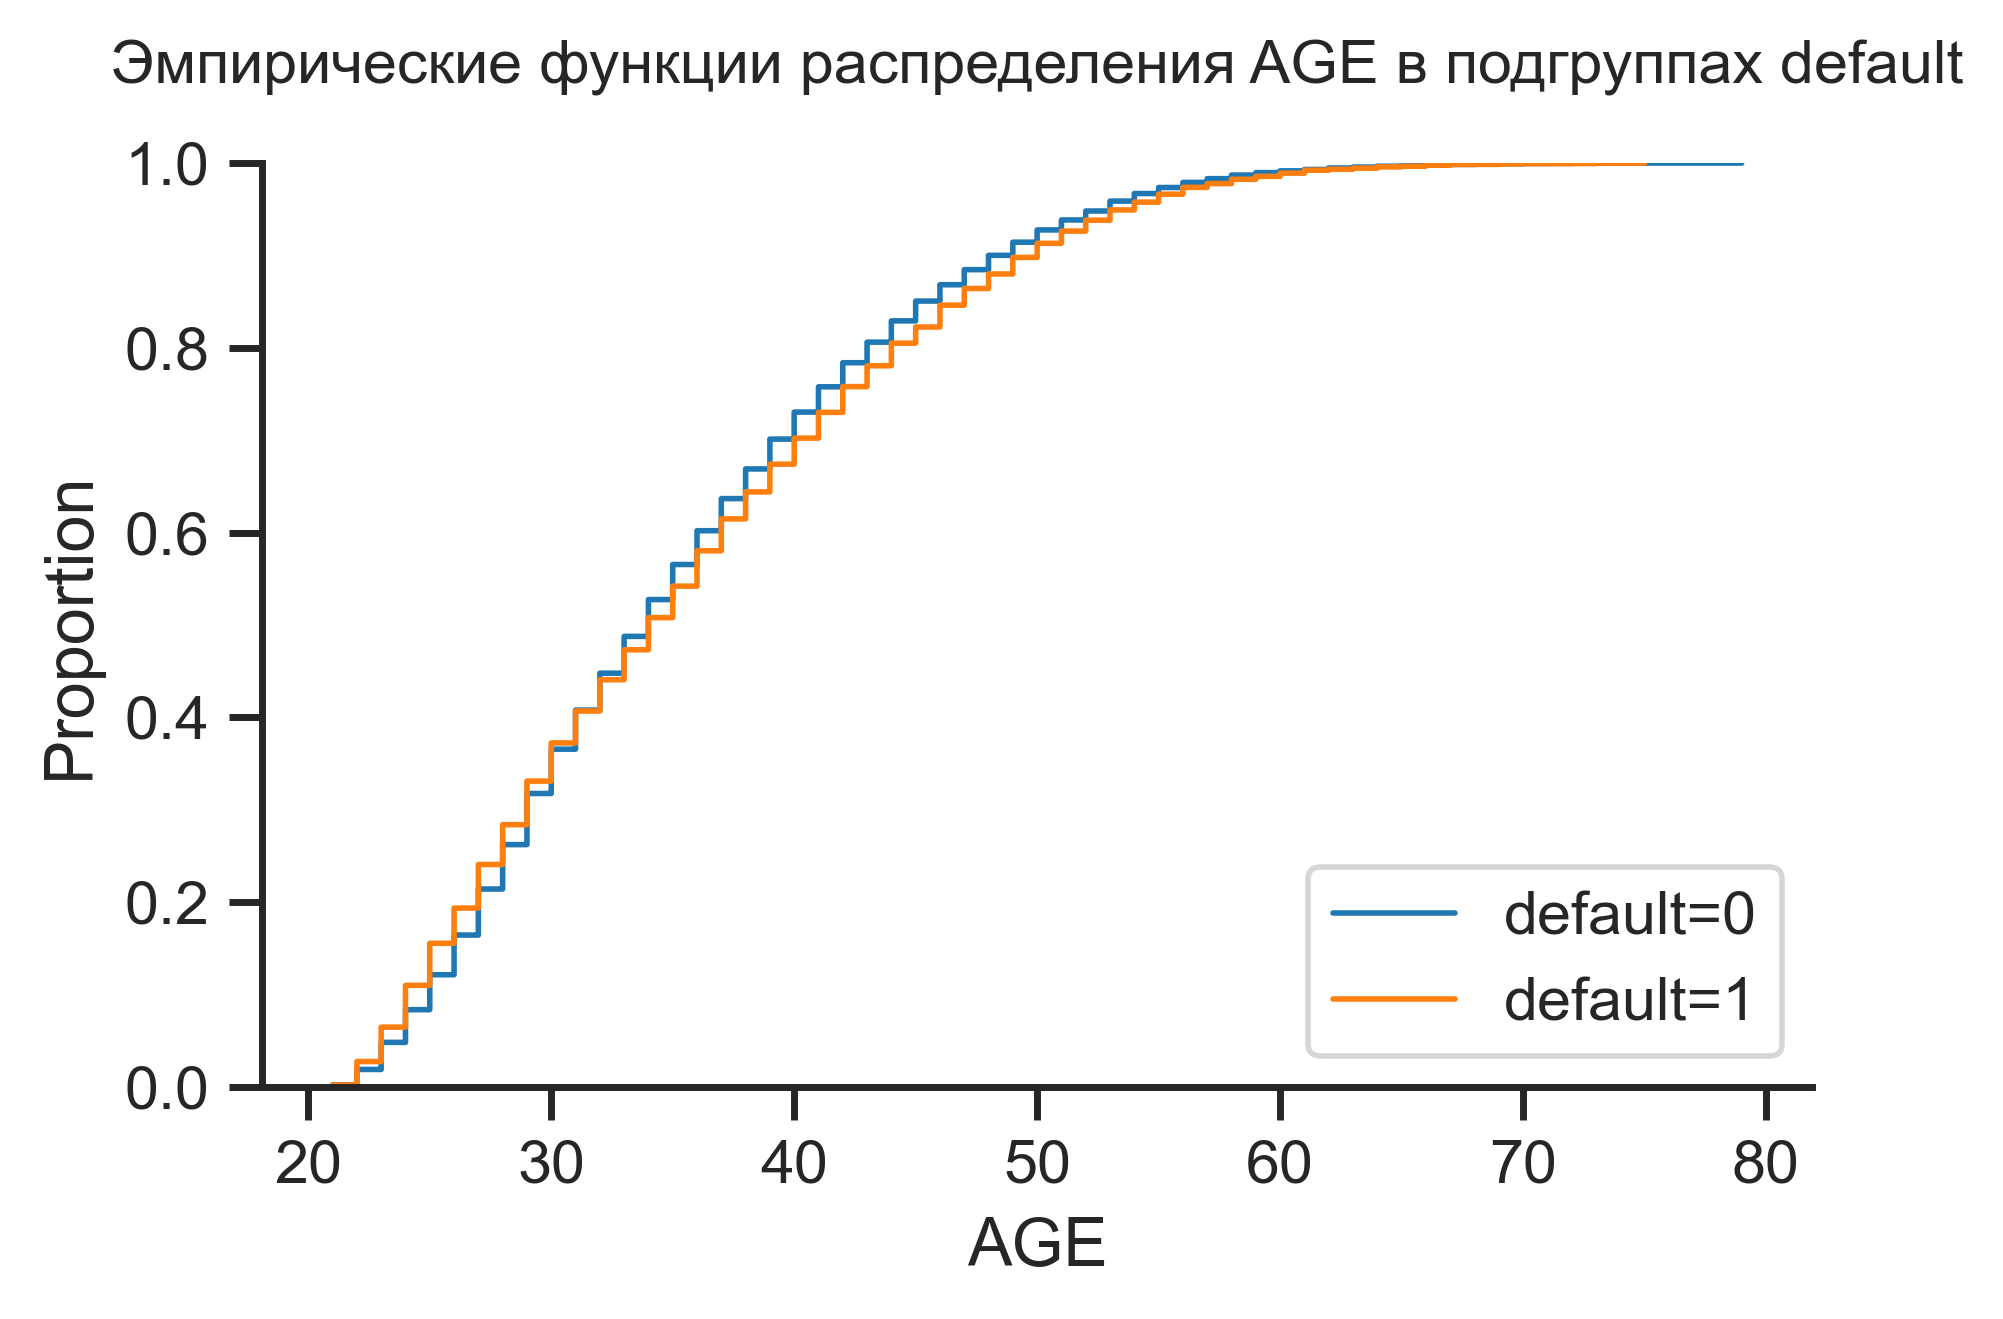

In [129]:
# эмпирические функции распределения AGE в подгруппах default
plt.figure(figsize=(5,3))
for default in (0, 1):
    sns.ecdfplot(samples[default], lw=1, c=f'C{default}', label=f'{default=}')
plt.title(title, size=11, y=1.05)
plt.legend(loc='lower right')
plt.show()

Тест Колмогорова-Смирнова на уровне значимости `ALPHA` уверенно отвергает гипотезу об общности распределения. На графике выше видно, что хотя эмпирические функции распределения и близки друг к другу, все же это разные распределения.

***
#### <a id='toc1_10_3_3_'></a>[__Оценка мощности статистического теста симуляциями Монте-Карло__](#toc0_)

Чтобы закрепить сделанный выше вывод о разных порождающих распределениях, оценим мощности перестановочного теста, U-теста Манна-Уитни и теста Колмогорова-Смирнова с помощью симуляций Монте-Карло.  

[__scipy.stats.monte_carlo_test__](https://docs.scipy.org/doc/scipy-1.11.3/reference/generated/scipy.stats.monte_carlo_test.html#scipy-stats-monte-carlo-test)
>Perform a Monte Carlo hypothesis test.<br>
_data_ contains a sample or a sequence of one or more samples. _rvs_ specifies the distribution(s) of the sample(s) in _data_ under the null hypothesis. The value of _statistic_ for the given _data_ is compared against a Monte Carlo null distribution: the value of the statistic for each of _n_resamples_ sets of samples generated using _rvs_. This gives the p-value, the probability of observing such an extreme value of the test statistic under the null hypothesis.

От `scipy.stats.monte_carlo_test` мы возьмем только готовый "движок", чтобы вытащить распределение достигнутых уровней значимости и по нему посчитать долю отклоняемых нулевых гипотез. 

In [114]:
@dataclasses.dataclass
class PowerMeter:
    """
    Мощность статистического теста симуляциями Монте-Карло.
    Рассчитывается при инициализации объекта.
    """
    samples: Iterable[array_like]
    statistic: Callable
    _: dataclasses.KW_ONLY
    alpha: float = ALPHA
    params: dict = dataclasses.field(default_factory=dict)
    
    @staticmethod
    def _sampler(sample, size) -> np.ndarray:
        rng = np.random.default_rng()
        return rng.choice(sample, size, replace=True)
    
    def __post_init__(self) -> None:
        rvs = [
            functools.partial(self.__class__._sampler, sample)
            for sample in self.samples
        ]
        self._res = stats.monte_carlo_test(
            self.samples, rvs, self.statistic, **self.params
        )
        self.power = (self._res.null_distribution < self.alpha).mean()
    
    def __repr__(self) -> str:
        attrs = {**self.__dict__}
        for key in ('samples', '_res'):
            del attrs[key]
        attrs['statistic'] = attrs['statistic'].__name__
        mode = black.Mode(line_length=40)
        return black.format_str(str(attrs), mode=mode)
    
    def plot(self) -> altair.vegalite.v5.api.Chart:
        null = pd.DataFrame(
            self._res.null_distribution, 
            columns=['pvalues']
        )
        chart = (
            altair.Chart(null).mark_bar()
            .properties(width=500, height=250)
            .interactive()
        )
        histogram = chart.encode(
            altair.X('pvalues:Q', bin=True),
            y='count()',
        )
        return histogram

In [115]:
def permutation_test_pvalue(*resamples):
    """
    statistic для инициализации объекта PowerMeter: pvalue перестановочного 
    теста. Не путать с statistic самого перестановочного теста. 
    """
    test = stats.permutation_test(resamples, statistic, n_resamples=1000)
    return test.pvalue

In [116]:
# [1000 x 1000] python 3.11 считает около 13 мин
permutation_meter = PowerMeter(
    samples, permutation_test_pvalue,
    params=dict(n_resamples=1000)
)
permutation_meter.power

0.681

In [117]:
permutation_meter.plot()

alt.Chart(...)

In [118]:
def mannwhitneyu_pvalue(*resamples):
    """
    statistic для инициализации объекта PowerMeter:
    pvalue U-теста Манна-Уитни.    
    """
    return stats.mannwhitneyu(*resamples).pvalue

In [119]:
mwu_meter = PowerMeter(
    samples, mannwhitneyu_pvalue, 
    params=dict(n_resamples=1000)
)
mwu_meter.power

0.15

In [120]:
mwu_meter

{
    "statistic": "mannwhitneyu_pvalue",
    "alpha": 0.05,
    "params": {"n_resamples": 1000},
    "power": 0.15,
}

In [121]:
mwu_meter.plot()

alt.Chart(...)

In [122]:
def kstest_pvalue(*resamples):
    """
    statistic для инициализации объекта PowerMeter:
    pvalue теста Колмогорова-Смирнова.    
    """
    return stats.kstest(*resamples).pvalue

In [123]:
# python 3.11: около 2 мин
kstest_meter = PowerMeter(samples, kstest_pvalue)
kstest_meter.power

1.0

__Мощность перестановочного теста заметно выше мощности U-теста Манна-Уитни ввиду того, что последний нечувствителен к магнитуде различий между величинами__.

***
#### <a id='toc1_10_3_4_'></a>[__Исследование связей с помощью индекса Кетле__](#toc0_)

Категоризируем `AGE` — бинаризуем на возрастные группы по $10$ лет и посмотрим, как они влияют на `default`.

In [124]:
# бины - возрастные группы AGE по 10 лет
bins = pd.IntervalIndex.from_tuples(
    [(20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80)], 
    closed='right'
)
bins

IntervalIndex([(20, 30], (30, 40], (40, 50], (50, 60], (60, 70], (70, 80]], dtype='interval[int64, right]')

In [125]:
# таблица сопряженности Возрастная группа AGE/default
table = pd.crosstab(pd.cut(data.AGE, bins=bins), data.default)
table

default,0,1
AGE,,
"(20, 30]",8542,2471
"(30, 40]",8524,2189
"(40, 50]",4606,1399
"(50, 60]",1493,504
"(60, 70]",189,68
"(70, 80]",10,5


In [126]:
# индексы Кетле для таблицы сопряженности Возрастная группа AGE/default
qtable = quetelet_index(table)
qtable = pd.DataFrame(qtable, table.index, columns=[0, 1])
qtable.index.name = 'Возрастная группа AGE'
qtable.columns.name = 'default'

In [127]:
# заголовок графика
title = (
    'Индексы Кетле\nдля таблицы сопряженности\n'
    'Возрастная группа AGE/default'
)

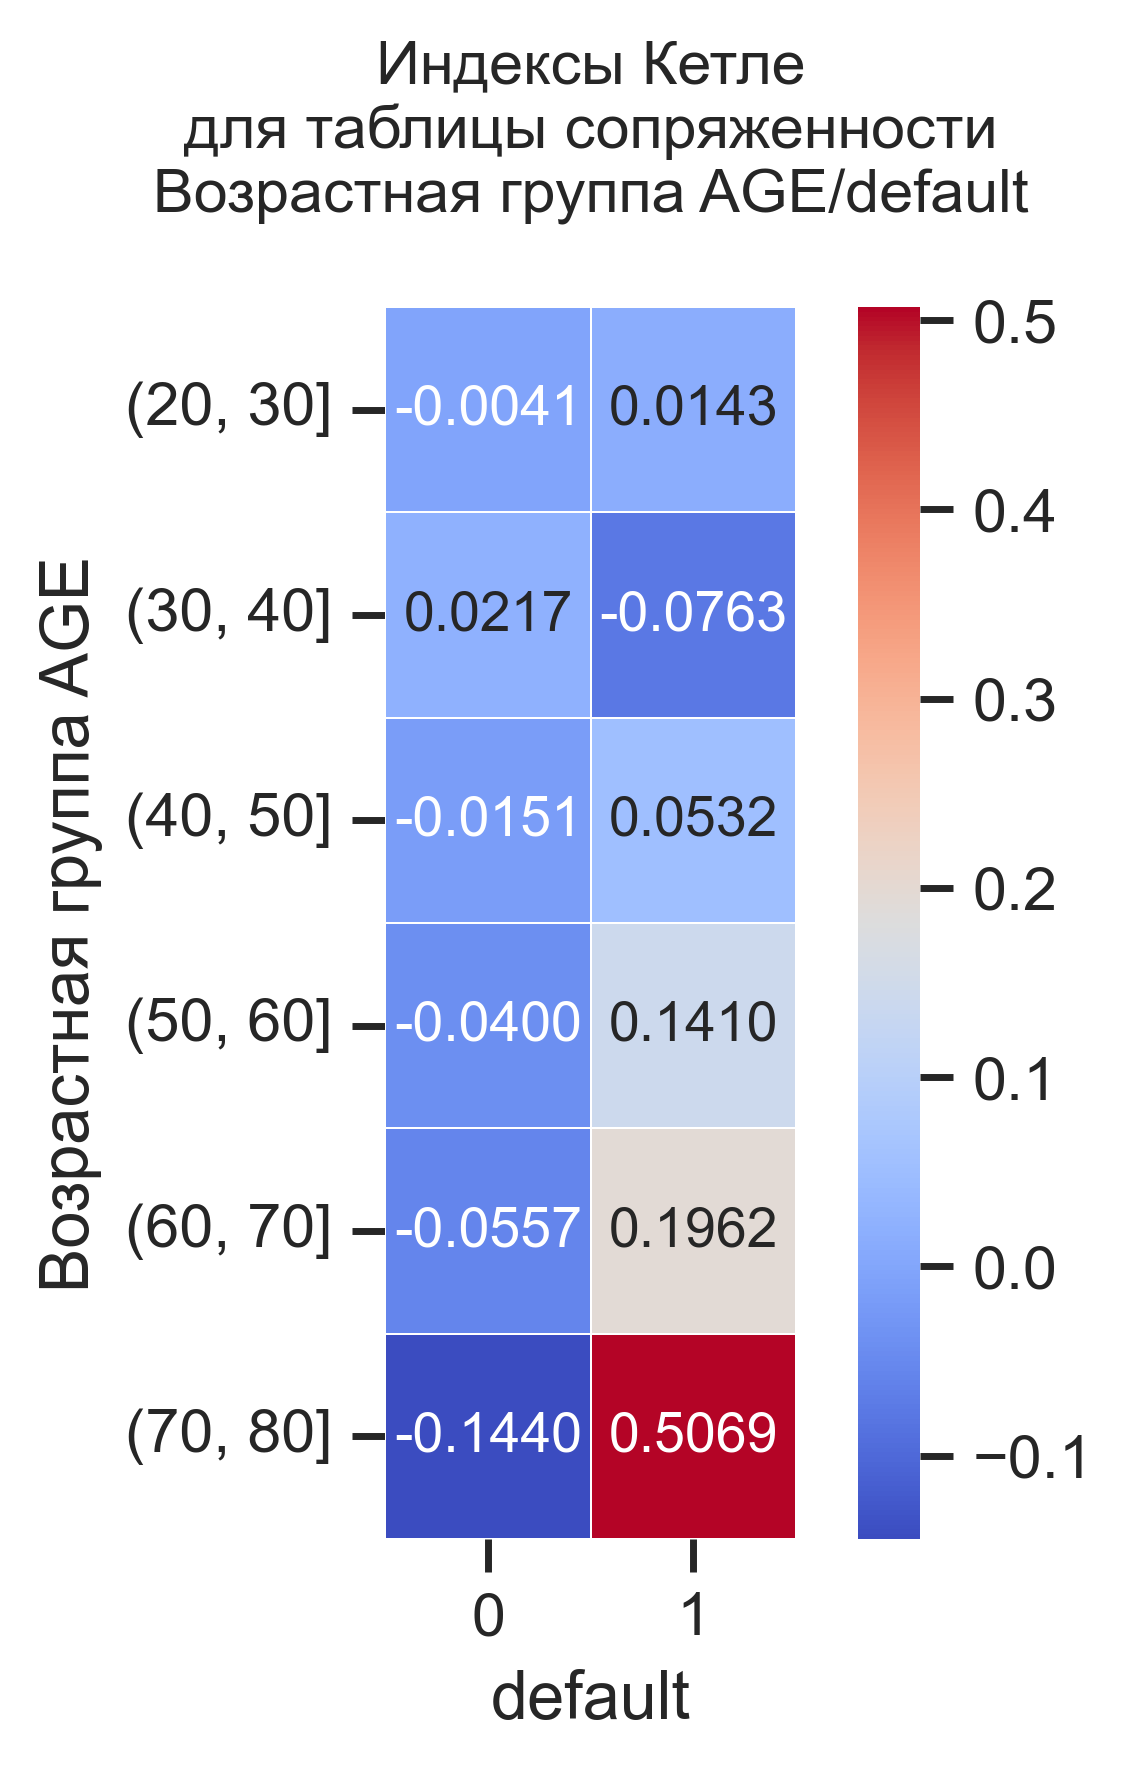

In [128]:
# тепловая карта индексов Кетле 
# для таблицы сопряженности Возрастная группа AGE/default
plt.figure(figsize=(4,4))
sns.heatmap(
    qtable, annot=True, fmt='.4f', annot_kws=dict(size=10),
    linewidths=0.3, square=True, cmap='coolwarm'
)
plt.yticks(rotation=0)
plt.title(title, size=11, y=1.05)
plt.show()

По индексам Кетле мы видим однозначную динамику: увеличение возраста заемщика повышает частоту категории _невозврат кредита_ и в категории _70+_ достигает более $50\%$. Теперь сдвиг `AGE` при `default=1` вправо относительно `AGE` при `default=0` получил свою качественную интерпретацию: подгруппа невернувших кредит тяготеет к старшим возрастным категориям заемщиков. 

***
### <a id='toc1_10_4_'></a>[__Выводы__](#toc0_)

* Гипотеза о равенстве медиан `AGE` в подгруппах `default` на уровне значимости `ALPHA` не отклонена.
* Гипотеза об общности распределения `AGE` в подгруппах `default` на уровне значимости `ALPHA` отклонена.
* Сдвиг `AGE` при `default=1` вправо относительно `AGE` при `default=0` получил свою качественную интерпретацию: подгруппа невернувших кредит тяготеет к старшим возрастным категориям заемщиков.

***